# Libraries

In [1]:
#%pip install tensorflow[and-cuda]
#%pip install ipywidgets
import tensorflow as tf
import random
import numpy as np
import numpy.random as rnd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
import itertools
from concurrent.futures import ProcessPoolExecutor
import csv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from datetime import datetime
import pandas as pd
from keras.saving import register_keras_serializable
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, recall_score, precision_score
import glob
%matplotlib inline
#plt.ion() 

# Global constants

session_length = 300
number_of_hid_units = 3
kelvin=273.15
np.random.seed(49)
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)


2025-04-28 11:15:08.479693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 11:15:08.487222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745838908.495647     288 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745838908.498155     288 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745838908.504498     288 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# limit GPU memory access 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])

# Modeling

In [4]:
'''Class for environment simulation'''

class environment():

    '''environment initializer'''

    def __init__(self, init_s):

        '''init_s: tuple of initial parameters

           self.t: temperature of air
           self.vent_degree: vent. level
           self.t_h: temperature of heater
           self.t_out: temperature outside, this values is also used as an average temperature for the calculated period
           self.c: 1 t_out is constant,0 it is modeled'''

        '''original fuction'''

        'self.t, self.vent_degree, self.t_h, self.t_w, self.t_out = init_s'

        'my version'

        self.t, self.vent_degree, self.t_h, self.t_w, self.t_out, self.c = init_s
        self.t_avg=self.t_out-4


    '''one step of environment'''


    def step2(self, a,scalled_step_n):


      '''a: tuple of actions
        heat: state of heater
        vent: state of vent.'''


      if scalled_step_n >= np.pi:
        n=math.floor(scalled_step_n/np.pi)
        scalled_step_n-=n*np.pi

      '''update of env. parameters'''

      'my version'

      t_c_fluid=np.interp(self.t_out,[293.15,318.1],[293.15,278.15])
      #self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(t_c_fluid-self.t)
      self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)

      t_w_fluid=np.interp(self.t_out,[253.15,318.1],[340.15,298.15])

      self.t_h += (t_w_fluid- self.t_h)*( 0.08 * a[0])-0.05*(self.t_h -self.t)


      self.t_w += 0.1 * (self.t - self.t_w) + 0.1 * (self.t_out - self.t_w)


      #self.t_w = self.t_w + 0.05 * (self.t - self.t_w) - 0.1 * (self.t_out - self.t_w)
      if self.c==1:
       self.t_out = self.t_out
      else:
        self.t_out += 0.01*np.cos(scalled_step_n-0.7)+(self.t_avg-self.t_out)*0.001+0.01*np.random.randn()

      '''checking of boundaries'''

      if self.t_h<kelvin:
            self.t_h = kelvin
      elif self.t_h>323.15:
            self.t_h = 323.15

      self.vent_degree = self.vent_degree - (1 - a[1]) + 3*a[1]

      if self.vent_degree<0:
          self.vent_degree = 0
      elif self.vent_degree>60:
          self.vent_degree = 60

      '''returns visible parameters of environment'''


      return self.t, self.vent_degree, self.t_out



    def step3(self, a,scalled_step_n, fault, multiplier=None ):

      '''a: tuple of actions
      heat: state of heater
      vent: state of vent.'''


      if scalled_step_n >= np.pi:
        n=math.floor(scalled_step_n/np.pi)
        scalled_step_n-=n*np.pi


      '''update of env. parameters'''

      'my version'



      if fault:
        self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*multiplier*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)
      else:
        self.t +=   0.032*(self.t_h - self.t) + 0.005*a[1]*(self.t_out-self.t)+ 0.025*(self.t_w - self.t) +0.016*a[2]*(283.15-self.t)

      t_w_fluid=np.interp(self.t_out,[253.15,318.1],[340.15,298.15])

      self.t_h += (t_w_fluid- self.t_h)*( 0.08 * a[0])-0.05*(self.t_h -self.t)


      self.t_w += 0.1 * (self.t - self.t_w) + 0.1 * (self.t_out - self.t_w)


      #self.t_w = self.t_w + 0.05 * (self.t - self.t_w) - 0.1 * (self.t_out - self.t_w)
      if self.c==1:
       self.t_out = self.t_out
      else:
        self.t_out += 0.01*np.cos(scalled_step_n-0.7)+(self.t_avg-self.t_out)*0.001+0.005*np.random.randn()

      '''checking of boundaries'''

      if self.t_h<kelvin:
            self.t_h = kelvin
      elif self.t_h>323.15:
            self.t_h = 323.15

      self.vent_degree = self.vent_degree - (1 - a[1]) + 3*a[1]

      if self.vent_degree<0:
          self.vent_degree = 0
      elif self.vent_degree>60:
          self.vent_degree = 60

      return self.t, self.vent_degree, self.t_out

    '''sample session with random control

       num_of_steps: number of time steps
       sigma: std deviation of additive noise
       '''

    '''sample session with random control

       num_of_steps: number of time steps
       sigma: std deviation of additive noise
       '''


    def controlled_session(self, num_of_steps, sigma,t_set,v_set,dt,dv):
      '''initializing sets of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []

      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)
      HoC=False
      '''for hvac, so a[0][0] is the heating on/off comand, a[0][1] for ventilation and a[0][2] for ac'''
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)

      '''main loop'''


      for i in range(num_of_steps):
        if i%300==0:
          if self.t_out<t_set-dt:
            HoC=True
          else:
            HoC=False
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        if noisy_t >= t_set+dt and HoC:
          a[0,0]=0
        elif noisy_t >= t_set+dt and not HoC:
          a[0,2]=1
        elif noisy_t <= t_set-dt and HoC:
          a[0,0]=1
        elif noisy_t <= t_set-dt and not HoC:
          a[0,2]=0
        if self.vent_degree> v_set+dv:
          a[0,1]=0
        elif self.vent_degree< v_set-dv:
          a[0,1]=1
        else:
          a[0,1]=a[0,1]


        collection_a=np.append(collection_a,a, axis=0)
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        t, vent, t_out = self.step2(a[0],scaled_step)
        noisy_t = t + sigma*np.random.randn()

      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out)

    def DR_session(self, num_of_steps, sigma,t_set,v_set,dt,dv, DR_start, confort_boundary):
      '''initializing sets of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []
      collection_DR=[]
      index=0
      check= False

      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)

      '''for hvac, so a[0][0] is the heating on/off comand, a[0][1] for ventilation and a[0][2] for ac'''
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)
      if self.t_out<t_set-dt:
        HoC=True
        boundary=t_set-confort_boundary
      else:
        HoC=False
        boundary=t_set+confort_boundary

      '''main loop'''

      for i in range(num_of_steps):
        if i==DR_start:
          check=True

        if check==False:
          collection_DR.append(0)
          if noisy_t >= t_set+dt and HoC:
            a[0,0]=0
          elif noisy_t >= t_set+dt and not HoC:
            a[0,2]=1
          elif noisy_t <= t_set-dt and HoC:
            a[0,0]=1
          elif noisy_t <= t_set-dt and not HoC:
            a[0,2]=0
          if self.vent_degree> v_set+dv:
            a[0,1]=0
          elif self.vent_degree< v_set-dv:
            a[0,1]=1
          else:
            a[0,1]=a[0,1]
        else:
          collection_DR.append(i-DR_start+1)
          if self.vent_degree> v_set+dv:
            a[0]=[0,0,0]
          elif self.vent_degree< v_set-dv:
            a[0]=[0,1,0]
          else:
            b=a[0,1]
            a[0]=[0,0,0]
            a[0,1]=b
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        collection_a=np.append(collection_a,a, axis=0)
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        t, vent, t_out = self.step2(a[0],scaled_step)
        noisy_t = t + sigma*np.random.randn()

        if abs(round(t,1)- round(boundary,1))<=0.25 and check== True:
          index=i
          #check= False



      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out), np.array(collection_DR), index,boundary


    def faulty_session(self, num_of_steps, sigma,t_set,v_set,dt,dv, fault_type,fault_start,increased_factor=None):
      """

      Args:
        num_of_steps:data generation window size, 1 step=1 minute
        sigma: std of the generated Gaussian noise
        t_set: goal temperature for the control system
        v_set:goal ventilation level for the control system
        dt: tolatence range for the goal temperature +-dt
        dv:tolatence range for the goal ventilation +-dt
        fault_type: select one of the possible faults to be modelled
                    0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

        fault_start: moment in time when the normal data becomes faulty data,
        set to 0 for faults that start before the generated data t0 or earlier,
        feed a random number between 150 and 300 to simulate the fault ocurring at any random time.
        increased_factor:None or float, the factor of how many times the insulation or noise level of the generated data would become worse
      """
      '''initializing history of of env. parameters'''
      collection_a = np.zeros((0,3), dtype=int)
      collection_t = []
      collection_noisy_t = []
      collection_t_out = []
      '''initializing  history of env. parameters for fault simulation'''
      collection_a_f = np.zeros((0,3), dtype=int) #for cases 0-3
      '''initial values of env. parameters'''
      t = self.t
      t_out = self.t_out
      noisy_t = t
      a = np.zeros((1,3), dtype=int)
      HoC=False
      OldRange = (1440 - 0)
      NewRange = (np.pi - 0)

      if self.t_out<t_set-dt:
        HoC=True

      else:
        HoC=False


      '''initial values of env. parameters for fault simulation'''
      a_f = np.copy(a)
      if increased_factor== None:
        multiplier=1.5
      else:
        multiplier=increased_factor
      '''main loop'''
      for i in range(num_of_steps):
        collection_t.append(t)
        collection_noisy_t.append(noisy_t)
        collection_t_out.append(t_out)
        if noisy_t >= t_set+dt and HoC:
          a[0,0]=0
        elif noisy_t >= t_set+dt and not HoC:
          a[0,2]=1
        elif noisy_t <= t_set-dt and HoC:
          a[0,0]=1
        elif noisy_t <= t_set-dt and not HoC:
          a[0,2]=0
        if self.vent_degree> v_set+dv:
          a[0,1]=0
        elif self.vent_degree< v_set-dv:
          a[0,1]=1
        else:
          a[0,1]=a[0,1]
        if fault_type==0:
          a_f = np.copy(a)
          a_f[0,0]=0
        elif fault_type==1:
          a_f = np.copy(a)
          a_f[0,0]=1
        elif fault_type==2:
          a_f = np.copy(a)
          a_f[0,2]=0
        elif fault_type==3:
          a_f = np.copy(a)
          a_f[0,2]=1
        collection_a=np.append(collection_a,a, axis=0)
        if (fault_type in [0,1,2,3] )and i>=fault_start:
          collection_a_f=np.append(collection_a_f,a_f, axis=0)
          a_for_agent = a_f[0]
        else:
          collection_a_f=np.append(collection_a_f,a, axis=0)
          a_for_agent = a[0]
        scaled_step = (((i - 0) * NewRange) / OldRange) + 0
        if fault_type==4  and i>=fault_start:
          t, _, t_out = self.step3(a_for_agent,scaled_step,multiplier=multiplier, fault= True)
        else:
          t, _, t_out = self.step3(a_for_agent,scaled_step,fault= False)
        if fault_type==5 and i>=fault_start:
          noisy_t = t + multiplier*sigma*np.random.randn()
        else:
          noisy_t = t + sigma*np.random.randn()

      '''returns set of t, set of t with additive gaussian noise, set of actions, set of outside temperatures'''

      return np.array(collection_t), np.array(collection_noisy_t), collection_a, np.array(collection_t_out),collection_a_f,HoC

def to_bin(x):
  y = (x*2**np.arange(x.shape[0]-1,-1,-1,dtype='int64')).sum()
  y = x.dot(1 << np.arange(x.size,dtype='int64')[::-1])
  return y

# Data generation

## Controlled data

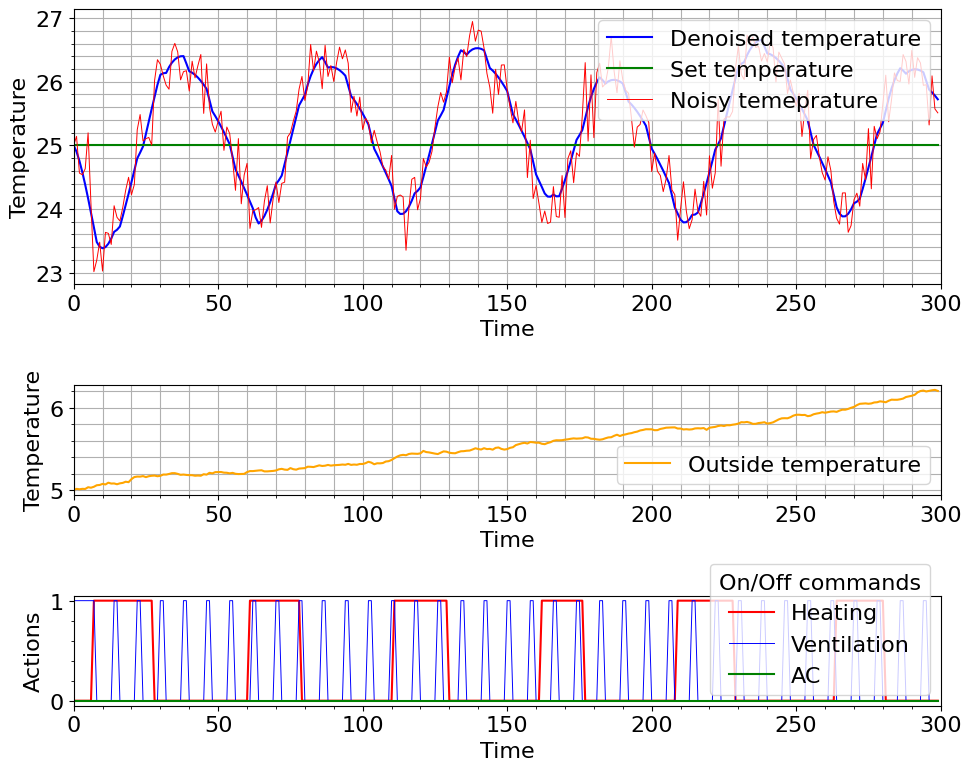

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/BML figures/simulation_example6.pdf'

In [185]:
'''generation of training set with target setpoints and constant t_out'''

"test for predictable behaviour"

#init_params_c = (298.15, 20, 298.15, 298.15, 298.15,1) #the room is termalised already
#init_params_c = (298.15, 20, 298.15, 298.15, 298.15,0) #the aerage temperature is the room initial temperature
#init_params_c = (298.15, 20, 298.15, 298.15, 293.15,0)# below by 5c from the set ponit
#init_params_c = (298.15, 20, 298.15, 298.15, 303.15,0)# up by 5c from the set ponit
#init_params_c = (298.15, 20, 298.15, 298.15, 240.15,1)# outside temperature low
init_params_c = (298.15, 20, 298.15, 298.15, 278.15,0)# outside temperature too low

'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 1


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 8
session_length = 300
std_of_noise = 0.3

#init_params_c = (298.15, 20, 298.15, 298.15, 313.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_c = environment(init_params_c)
s_length = number_of_pieces * session_length
t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)

'''reshaping dataset in appropriate for learning form'''
t_out_c = t_out_c.reshape((number_of_pieces, session_length))
t_out_c=t_out_c-kelvin
t_c = t_c.reshape((number_of_pieces, session_length))
t_c=t_c-kelvin
noisy_t_c = noisy_t_c.reshape((number_of_pieces, session_length))
noisy_t_c=noisy_t_c-kelvin
a_c_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_c)):
  y=to_bin(a_c[i])
  a_c_dec=np.append(a_c_dec,np.array([y]).reshape((1,1)), axis=0)
a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
heat_c =a_c[:,0].reshape((number_of_pieces, session_length))
vent_c = a_c[:,1].reshape((number_of_pieces, session_length))
ac_c=a_c[:,2].reshape((number_of_pieces, session_length))
t_set=t_set-kelvin

'''plotting of example'''
'''plotting of example'''
n0=0
fig, axs = plt.subplots(3, 1,gridspec_kw={'height_ratios': [2.5, 1,1]})
fig.set_figwidth(10)
fig.set_figheight(8)
axs[0].plot(t_c[n0], 'b',label="Denoised temperature")
#axs[0].plot(t_out_c[n0], 'orange',label="Outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="Set temperature")
axs[0].plot(noisy_t_c[n0], 'r',label="Noisy temeprature",linewidth=.7)
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(loc=1)
axs[1].plot(t_out_c[n0], 'orange',label="Outside temperature")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Temperature')
axs[1].grid(True)
axs[1].grid(which = "minor")
axs[1].minorticks_on()
axs[1].legend(loc=4)
axs[2].plot(heat_c[n0], 'r',label="Heating")
axs[2].plot(vent_c[n0], 'b',label="Ventilation",linewidth=.7)
axs[2].plot(ac_c[n0], 'g',label="AC")
axs[2].set_xlim(0, 300)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Actions')
axs[2].grid(True)
axs[2].legend(loc=0, title='On/Off commands')
axs[2].grid(which = "major")
axs[2].minorticks_on()
fig.tight_layout()
plt.show()
test_n=6
fig.savefig('/content/drive/MyDrive/Colab Notebooks/BML figures/simulation_example'+str(test_n)+'.pdf', format='pdf')

## DR simulation

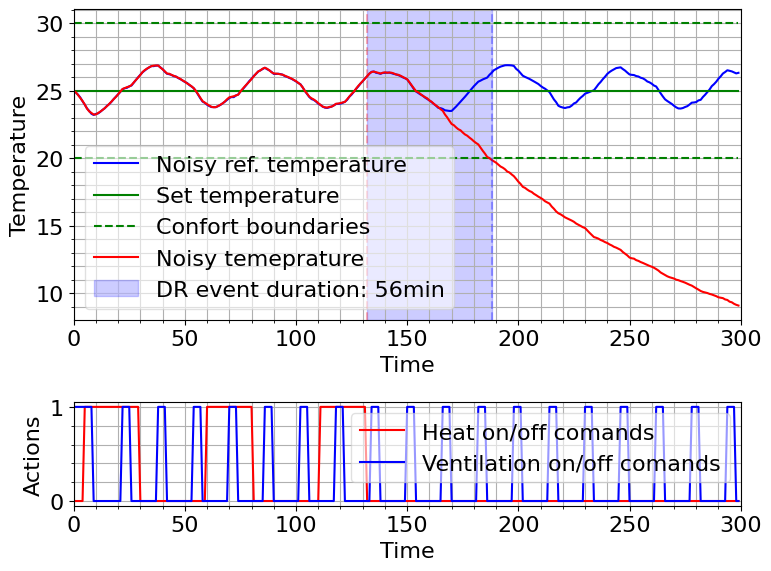

In [ ]:
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5
DR_start=132
boundary=5
'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
std_of_noise = 0.015

init_params_dr = (298.15, 20, 298.15, 298.15, 273.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_dr = environment(init_params_dr)
env_ref = environment(init_params_dr)
s_length = number_of_pieces * session_length

t_dr, noisy_t_dr, a_dr, t_out_dr,dr,index,conf_lim= env_dr.DR_session(s_length, std_of_noise,t_set,v_set,dt,dv,DR_start,boundary)
t_ref,noisy_t_ref,_,_=env_ref.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)

'''reshaping dataset in appropriate for learning form'''
t_out_dr = t_out_dr.reshape((number_of_pieces, session_length))
t_out_dr=t_out_dr-kelvin
t_dr = t_dr.reshape((number_of_pieces, session_length))
t_dr=t_dr-kelvin
noisy_t_dr = noisy_t_dr.reshape((number_of_pieces, session_length))
noisy_t_dr=noisy_t_dr-kelvin
a_dr_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_dr)):
  y=to_bin(a_dr[i])
  a_dr_dec=np.append(a_dr_dec,np.array([y]).reshape((1,1)), axis=0)
a_dr_dec = a_dr_dec.reshape((number_of_pieces, session_length))
heat_dr =a_dr[:,0].reshape((number_of_pieces, session_length))
vent_dr = a_dr[:,1].reshape((number_of_pieces, session_length))
ac_dr=a_dr[:,2].reshape((number_of_pieces, session_length))
t_set=t_set-kelvin

noisy_t_ref = noisy_t_ref.reshape((number_of_pieces, session_length))
noisy_t_ref=noisy_t_ref-kelvin
conf_lim= conf_lim- kelvin
'''plotting of example'''
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [3, 1]})
fig.set_figwidth(8)
fig.set_figheight(6)
#axs[0].plot(t_dr[0], 'y',label="denoised DR temperature")
axs[0].plot(noisy_t_ref[0], 'b',label="Noisy ref. temperature")
#axs[0].plot(t_out_dr[0], 'orange',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="Set temperature")
axs[0].plot((t_set-boundary)*np.ones(300), 'g',label="Confort boundaries",linestyle='dashed')
axs[0].plot((t_set+boundary)*np.ones(300), 'g',linestyle='dashed')
axs[0].plot(noisy_t_dr[0], 'r',label="Noisy temeprature")
axs[0].axvspan(DR_start,index,color = 'b', label = 'DR event duration: '+str(index-DR_start)+'min',alpha=0.2)
axs[0].axvline(x = DR_start, color = 'r',linestyle='dashed',alpha=0.3)
axs[0].axvline(x = index, color = 'b',linestyle='dashed',alpha=0.3)
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(framealpha=0.6,loc= 'lower left')
axs[1].plot(heat_dr[0], 'r',label="Heat on/off comands")
axs[1].plot(vent_dr[0], 'b',label="Ventilation on/off comands")
#axs[1].plot(ac_dr[0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend(framealpha=0.6)
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()


In [ ]:

fig.savefig('/content/drive/MyDrive/Colab Notebooks/BML figures/DR_planning_ max_duration.pdf', format='pdf')

## Fault data

1


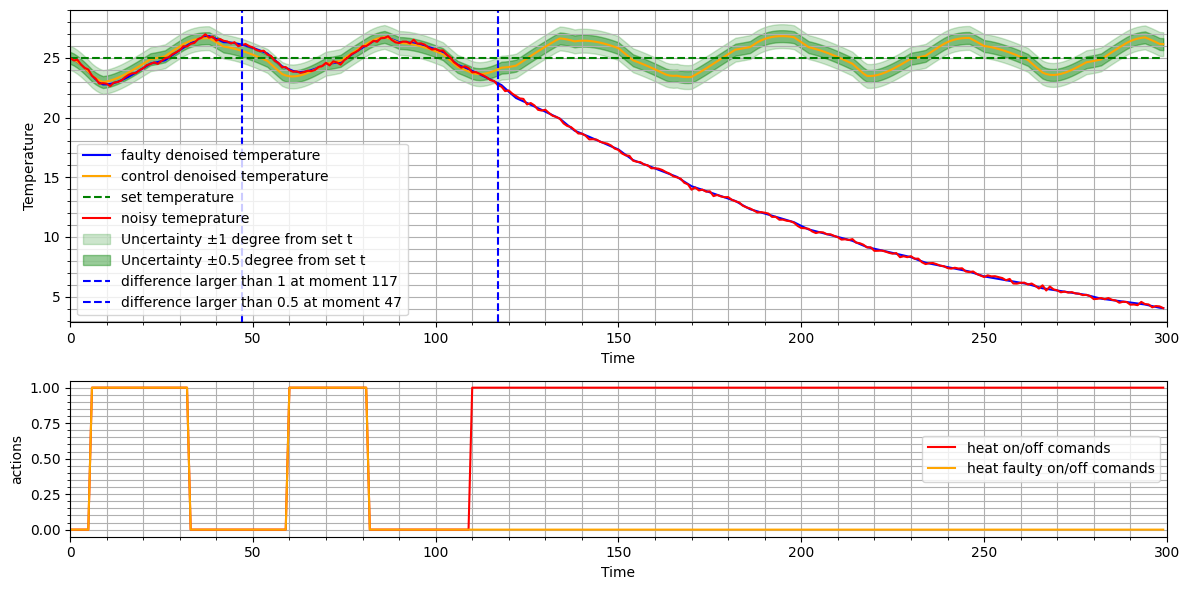

In [ ]:
"""fault_type: select one of the possible faults to be modelled
                     0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

         fault_start: moment in time when the normal data becomes faulty data,
          set to 0 for faults that start before the generated data t0 or earlier,
          feed a random number between 150 and 300 to simulate the fault ocurring at any random time.
          increased_factor:None or float, the factor of how many times the insulation or noise level of the generated data would become worse
"""

'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
std_of_noise = 0.1

init_params_f = (298.15, 20, 298.15, 298.15, 273.15,0) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
env_f = environment(init_params_f)
s_length = number_of_pieces * session_length
t_f, noisy_t_f, a_f, t_out_f,a_fault,_= env_f.faulty_session(s_length, std_of_noise,t_set,v_set,dt,dv, fault_type=0, fault_start=100,increased_factor=2.5)
env_c = environment(init_params_f)
t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)
'''reshaping dataset in appropriate for learning form'''
t_out_f = t_out_f.reshape((number_of_pieces, session_length))
t_out_f=t_out_f-kelvin
t_f = t_f.reshape((number_of_pieces, session_length))
t_f=t_f-kelvin
t_c = t_c.reshape((number_of_pieces, session_length))
t_c=t_c-kelvin
noisy_t_f = noisy_t_f.reshape((number_of_pieces, session_length))
noisy_t_f=noisy_t_f-kelvin
t_set=t_set-kelvin


a_f_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_f)):
  y=to_bin(a_f[i])
  a_f_dec=np.append(a_f_dec,np.array([y]).reshape((1,1)), axis=0)
a_f_dec = a_f_dec.reshape((number_of_pieces, session_length))
heat_f =a_f[:,0].reshape((number_of_pieces, session_length))
vent_f = a_f[:,1].reshape((number_of_pieces, session_length))
ac_f=a_f[:,2].reshape((number_of_pieces, session_length))


a_fault_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_fault)):
  y=to_bin(a_fault[i])
  a_fault_dec=np.append(a_fault_dec,np.array([y]).reshape((1,1)), axis=0)
a_fault_dec = a_fault_dec.reshape((number_of_pieces, session_length))
heat_fault =a_fault[:,0].reshape((number_of_pieces, session_length))
vent_fault = a_fault[:,1].reshape((number_of_pieces, session_length))
ac_fault=a_fault[:,2].reshape((number_of_pieces, session_length))


'''plotting of example'''
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(t_f[0], 'b',label="faulty denoised temperature")
axs[0].plot(t_c[0], 'orange',label="control denoised temperature")
#axs[0].plot(t_out_f[0], 'black',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="set temperature",linestyle='dashed')
axs[0].plot(noisy_t_f[0], 'r',label="noisy temeprature")
axs[0].fill_between(range(300), t_c[0] - 1, t_c[0] + 1, color='green', alpha=0.2, label='Uncertainty ±1 degree from set t')
axs[0].fill_between(range(300), t_c[0] - 0.5, t_c[0] + 0.5, color='green', alpha=0.4, label='Uncertainty ±0.5 degree from set t')

limit_1 = None
limit_2 = None
outside_1 = (t_f[0] < t_c[0] - 1) | (t_f[0] > t_c[0] + 1)
outside_2 = (t_f[0] < t_c[0] - 0.5) | (t_f[0] > t_c[0] + 0.5)
for i in range(300):
    if outside_1[i] and limit_1 is None:
        limit_1 = i
if limit_1 is not None:
    axs[0].axvline(x = limit_1, color = 'b', label = 'difference larger than 1 at moment '+str(limit_1),linestyle='dashed')
for i in range(300):
    if outside_2[i] and limit_2 is None:
        limit_2 = i
if limit_2 is not None:
    axs[0].axvline(x = limit_2, color = 'b', label = 'difference larger than 0.5 at moment '+str(limit_2),linestyle='dashed')
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(heat_f[0], 'r',label="heat on/off comands")
#axs[1].plot(vent_f[0], 'b',label="ventilation on/off comands")
axs[1].plot(heat_fault[0], 'orange',label="heat faulty on/off comands")
#axs[1].plot(vent_fault[0], 'green',label="ventilation faulty on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()


In [ ]:
_

True

## training bach data generation

In [182]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 8
session_length = 300
s_length = number_of_pieces * session_length

std_of_noise =np.round(np.linspace(0.01,0.5,5),decimals=2)
t_start=np.round(np.linspace(293.15,303.15,5),decimals=2)
v_start= np.round(np.linspace(20,60,4),decimals=2)
t_h_start= np.round(np.linspace(293.15,340.15,5),decimals=2)
t_w_start= np.round(np.linspace(273.15,308.15,10),decimals=2)
t_out_start= np.round(np.linspace(253.15,295.15,15),decimals=2)
init_params_c = list(itertools.product(t_start, v_start, t_h_start, t_w_start, t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#init_params_c_tset = list(itertools.product(t_start, v_start, t_h_start, t_w_start, [t_set],[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#inint_test=init_params_c+init_params_c_tset+init_params_c_tset+init_params_c_tset+init_params_c_tset
init_params_c_sh= random.sample(init_params_c, len(init_params_c))
np.random.shuffle(std_of_noise)

In [184]:
t_start

array([293.15, 295.65, 298.15, 300.65, 303.15])

In [ ]:
len(init_params_c_sh)

15000

In [ ]:
t_out_c = np.empty([number_of_pieces, session_length])
t_c=np.empty([number_of_pieces, session_length])
noisy_t_c=np.empty([number_of_pieces, session_length])
a_c=np.empty([number_of_pieces, session_length])




for i in tqdm(range(0,500)):
  env_c = environment(init_params_c_sh[i])
  for j in range(len(std_of_noise)):
    t_ci, noisy_t_ci, a_ci, t_out_ci = env_c.controlled_session(s_length, std_of_noise[j],t_set,v_set,dt,dv)

    '''reshaping dataset in appropriate for learning form'''
    t_out_ci = t_out_ci.reshape((number_of_pieces, session_length))
    t_out_ci=t_out_ci[1]-kelvin
    t_ci = t_ci.reshape((number_of_pieces, session_length))
    t_ci=t_ci[1]-kelvin
    noisy_t_ci = noisy_t_ci.reshape((number_of_pieces, session_length))
    noisy_t_ci=noisy_t_ci[1]-kelvin
    a_c_dec= np.zeros((0,1), dtype=int)
    for i in range(len(a_ci)):
      y=to_bin(a_ci[i])
      a_c_dec=np.append(a_c_dec,np.array([y]).reshape(1,1), axis=0)
    a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
    a_c_dec = a_c_dec[1]
    #heat_c,vent_c = np.unravel_index(a_c, (2, 2))


    #concatenate

    t_out_c=np.vstack((t_out_c,t_out_ci))
    t_c=np.vstack((t_c,t_ci))
    noisy_t_c=np.vstack((noisy_t_c,noisy_t_ci))
    a_c=np.vstack((a_c,a_c_dec))
t_out_c=t_out_c[number_of_pieces:,:]
t_c=t_c[number_of_pieces:,:]
noisy_t_c=noisy_t_c[number_of_pieces:,:]
a_c=a_c[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_heatingonly.npz', t_out_c=t_out_c, t_c=t_c,noisy_t_c=noisy_t_c,a_c=a_c)

## tests batch dataset


In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 2
session_length = 300
s_length = number_of_pieces * session_length

std_of_noise =[0.8]
t_start=np.round(np.linspace(293.15,303.15,8),decimals=2)
v_start= np.round(np.linspace(20,60,10),decimals=2)
t_h_start= np.round(np.linspace(293.15,340.15,8),decimals=2)
t_w_start= np.round(np.linspace(273.15,308.15,14),decimals=2)
t_out_start= np.round(np.linspace(253.15,290.15,8),decimals=2)
init_params_c = list(itertools.product(t_start, v_start, t_h_start, t_w_start, t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
init_params_c_tset = list(itertools.product(t_start, v_start, t_h_start, t_w_start, [t_set],[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#inint_test=init_params_c+init_params_c_tset+init_params_c_tset+init_params_c_tset+init_params_c_tset
init_params_c_sh= random.sample(init_params_c, len(init_params_c))
#np.random.shuffle(std_of_noise)

In [ ]:
std_of_noise

[0.8]

In [ ]:
t_out_c = np.empty([number_of_pieces, session_length])
t_c=np.empty([number_of_pieces, session_length])
noisy_t_c=np.empty([number_of_pieces, session_length])
a_c=np.empty([number_of_pieces, session_length])




for i in tqdm(range(0,500)):
  env_c = environment(init_params_c_sh[i])
  for j in range(len(std_of_noise)):
    t_ci, noisy_t_ci, a_ci, t_out_ci = env_c.controlled_session(s_length, std_of_noise[j],t_set,v_set,dt,dv)

    '''reshaping dataset in appropriate for learning form'''
    t_out_ci = t_out_ci.reshape((number_of_pieces, session_length))
    t_out_ci=t_out_ci[1]-kelvin
    t_ci = t_ci.reshape((number_of_pieces, session_length))
    t_ci=t_ci[1]-kelvin
    noisy_t_ci = noisy_t_ci.reshape((number_of_pieces, session_length))
    noisy_t_ci=noisy_t_ci[1]-kelvin
    a_c_dec= np.zeros((0,1), dtype=int)
    for i in range(len(a_ci)):
      y=to_bin(a_ci[i])
      a_c_dec=np.append(a_c_dec,np.array([y]).reshape(1,1), axis=0)
    a_c_dec = a_c_dec.reshape((number_of_pieces, session_length))
    a_c_dec = a_c_dec[1]
    #heat_c,vent_c = np.unravel_index(a_c, (2, 2))


    #concatenate

    t_out_c=np.vstack((t_out_c,t_out_ci))
    t_c=np.vstack((t_c,t_ci))
    noisy_t_c=np.vstack((noisy_t_c,noisy_t_ci))
    a_c=np.vstack((a_c,a_c_dec))
t_out_c=t_out_c[number_of_pieces:,:]
t_c=t_c[number_of_pieces:,:]
noisy_t_c=noisy_t_c[number_of_pieces:,:]
a_c=a_c[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_noise_effect_test.npz', t_out_c=t_out_c[number_of_pieces:], t_c=t_c[number_of_pieces:],noisy_t_c=noisy_t_c[number_of_pieces:],a_c=a_c[number_of_pieces:])

## DR test batch dataset

In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5

'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
s_length = number_of_pieces * session_length
std_of_noise =0.1
t_start=298.15
v_start= 40
t_h_start= 298.15
t_w_start= 298.15
#t_out_start=np.round(np.linspace(258.15,291.15,5),decimals=1)
t_out_start= np.round(np.linspace(302.15,310.15,5),decimals=1)
#t_out_start= np.concatenate((np.round(np.linspace(258.15,291.15,5),decimals=1), np.round(np.linspace(302.15,310.15,5),decimals=1)), axis=None)
init_params_c = list(itertools.product([t_start], [v_start], [t_h_start], [t_w_start], t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
init_params_c= random.sample(init_params_c, len(init_params_c))
DR_start=np.round(np.linspace(190,220,20),decimals=0)
np.random.shuffle(DR_start)
boundary=[4,4.5,5,5.5,6]

In [ ]:
init_params_c

[(298.15, 40, 298.15, 298.15, 302.2, 0),
 (298.15, 40, 298.15, 298.15, 310.2, 0),
 (298.15, 40, 298.15, 298.15, 308.2, 0),
 (298.15, 40, 298.15, 298.15, 304.2, 0),
 (298.15, 40, 298.15, 298.15, 306.2, 0)]

In [ ]:
t_out_dr = np.empty([number_of_pieces, session_length])
t_dr=np.empty([number_of_pieces, session_length])
noisy_t_dr=np.empty([number_of_pieces, session_length])
a_dr=np.empty([number_of_pieces, session_length])
dr=np.empty([number_of_pieces, session_length])
index=np.empty([number_of_pieces,1])
conf_lim=np.empty([number_of_pieces,1])
for i in tqdm(init_params_c):
  for j in DR_start:
    for p in boundary:
      env_c = environment(i)

      t_dri, noisy_t_dri, a_dri,t_out_dri,dr_i,index_i,conf_lim_i,= env_c.DR_session(s_length, std_of_noise,t_set,v_set,dt,dv,j,p)

      '''reshaping dataset in appropriate for learning form'''
      t_out_dri = t_out_dri.reshape((number_of_pieces, session_length))
      t_out_dri=t_out_dri-kelvin
      t_dri = t_dri.reshape((number_of_pieces, session_length))
      t_dri=t_dri-kelvin
      noisy_t_dri = noisy_t_dri.reshape((number_of_pieces, session_length))
      noisy_t_dri=noisy_t_dri-kelvin
      a_dr_dec= np.zeros((0,1), dtype=int)
      for k in range(len(a_dri)):
        y=to_bin(a_dri[k])
        a_dr_dec=np.append(a_dr_dec,np.array([y]).reshape(1,1), axis=0)
      a_dr_dec = a_dr_dec.reshape((number_of_pieces, session_length))
      dr_i=dr_i.reshape((number_of_pieces, session_length))


      #heat_dr,vent_dr = np.unravel_index(a_dr, (2, 2))


      #concatenate

      t_out_dr=np.vstack((t_out_dr,t_out_dri))
      t_dr=np.vstack((t_dr,t_dri))
      noisy_t_dr=np.vstack((noisy_t_dr,noisy_t_dri))
      a_dr=np.vstack((a_dr,a_dr_dec))
      dr=np.vstack((dr,dr_i))
      index=np.vstack((index,index_i))
      conf_lim=np.vstack((conf_lim,conf_lim_i-kelvin))
t_out_dr=t_out_dr[number_of_pieces:,:]
t_dr=t_dr[number_of_pieces:,:]
noisy_t_dr=noisy_t_dr[number_of_pieces:,:]
a_dr=a_dr[number_of_pieces:,:]
dr=dr[number_of_pieces:,:]
index=index[number_of_pieces:,:]
conf_lim=conf_lim[number_of_pieces:,:]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train_cooling.npz', t_out_dr=t_out_dr, t_dr=t_dr,noisy_t_dr=noisy_t_dr,a_dr=a_dr,dr=dr,index=index,conf_lim=conf_lim)

## Batch fault data set

In [ ]:
#create data set with 25c as the target temperature and 40 as the ventilation setpoint, and different verage outside temperatures
'''evironment initialization'''
t_set=298.15
v_set=40
dt= 1
dv= 5


'''sample session with given length and std (total length of session: number_of_pieces * session_length)'''
number_of_pieces = 1
session_length = 300
s_length = number_of_pieces * session_length

fault_type=5

std_of_noise =0.01
t_start=np.round(np.linspace(293.15,303.15,20),decimals=2)
v_start= 40
t_h_start= 298.15
t_w_start= 298.15
t_out_start= np.concatenate((np.round(np.linspace(258.15,297.1,15),decimals=1), np.round(np.linspace(297.15,310.15,10),decimals=1)), axis=None)
init_params_c = list(itertools.product(t_start, [v_start], [t_h_start], [t_w_start], t_out_start,[0])) #temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
#init_params_c_sh= random.sample(init_params_c, len(init_params_c))
#np.random.shuffle(std_of_noise)

In [ ]:
"""fault_type: select one of the possible faults to be modelled
                      0: at fault_start time the Heating becomes unresponsive and turns off,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    1:at fault_start time the Heating becomes unresponsive and turns on,
                    the system will generate the regular heating response based on sensing data,
                    whitout affecting the real state of the heating.
                    2: at fault_start time the cooling becomes unresponsive and turns off,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    3:at fault_start time the cooling becomes unresponsive and turns on,
                    the system will generate the regular cooling response based on sensing data,
                    whitout affecting the real state of the cooling.
                    4:at fault_start time the insolation becomes 1.5 times worse or the given increased_factor times worse (do last)
                    5:at fault_start time the sensor data becomes 1.5 times worse or the given increased_factor times worse

"""

number_of_pieces = 1
t_out_f = np.empty([number_of_pieces, session_length])
t_f=np.empty([number_of_pieces, session_length])
noisy_t_f=np.empty([number_of_pieces, session_length])
a_f=np.empty([number_of_pieces, session_length])
a_fault=np.empty([number_of_pieces, session_length])
check=np.empty([number_of_pieces,1])
for i in tqdm(init_params_c):
  env_f = environment(i)
  t_fi, noisy_t_fi, a_fi, t_out_fi,a_faulti,_ = env_f.faulty_session(s_length, std_of_noise,t_set,v_set,dt,dv, fault_type=fault_type, fault_start=170,increased_factor=2.5)
  check=np.append(check,_)
  #env_c = environment(init_params_c)
  #t_c, noisy_t_c, a_c, t_out_c = env_c.controlled_session(s_length, std_of_noise,t_set,v_set,dt,dv)
  '''reshaping dataset in appropriate for learning form'''
  t_out_fi = t_out_fi.reshape((number_of_pieces, session_length))
  t_out_fi=t_out_fi-kelvin
  t_fi = t_fi.reshape((number_of_pieces, session_length))
  t_fi=t_fi-kelvin
  #t_c = t_c.reshape((number_of_pieces, session_length))
  #t_c=t_c-kelvin
  noisy_t_fi = noisy_t_fi.reshape((number_of_pieces, session_length))
  noisy_t_fi=noisy_t_fi-kelvin



  a_fi_dec= np.zeros((0,1), dtype=int)
  for i in range(len(a_fi)):
    y=to_bin(a_fi[i])
    a_fi_dec=np.append(a_fi_dec,np.array([y]).reshape((1,1)), axis=0)
  a_fi_dec = a_fi_dec.reshape((number_of_pieces, session_length))
  a_faulti_dec= np.zeros((0,1), dtype=int)
  for i in range(len(a_faulti)):
    y=to_bin(a_faulti[i])
    a_faulti_dec=np.append(a_faulti_dec,np.array([y]).reshape((1,1)), axis=0)
  a_faulti_dec = a_faulti_dec.reshape((number_of_pieces, session_length))
  t_out_f=np.vstack((t_out_f,t_out_fi))
  t_f=np.vstack((t_f,t_fi))
  noisy_t_f=np.vstack((noisy_t_f,noisy_t_fi))
  a_f=np.vstack((a_f,a_fi_dec))
  a_fault=np.vstack((a_fault,a_faulti_dec))
'''
a_fault_dec= np.zeros((0,1), dtype=int)
for i in range(len(a_fault)):
  y=to_bin(a_fault[i])
  a_fault_dec=np.append(a_fault_dec,np.array([y]).reshape((1,1)), axis=0)
a_fault_dec = a_fault_dec.reshape((number_of_pieces, session_length))
heat_fault =a_fault[:,0].reshape((number_of_pieces, session_length))
vent_fault = a_fault[:,1].reshape((number_of_pieces, session_length))
ac_fault=a_fault[:,2].reshape((number_of_pieces, session_length))

'''

t_out_f=t_out_f[number_of_pieces:,:]
t_f=t_f[number_of_pieces:,:]
noisy_t_f=noisy_t_f[number_of_pieces:,:]
a_f=a_f[number_of_pieces:,:]
a_fault=a_fault[number_of_pieces:,:]

  0%|          | 0/500 [00:00<?, ?it/s]

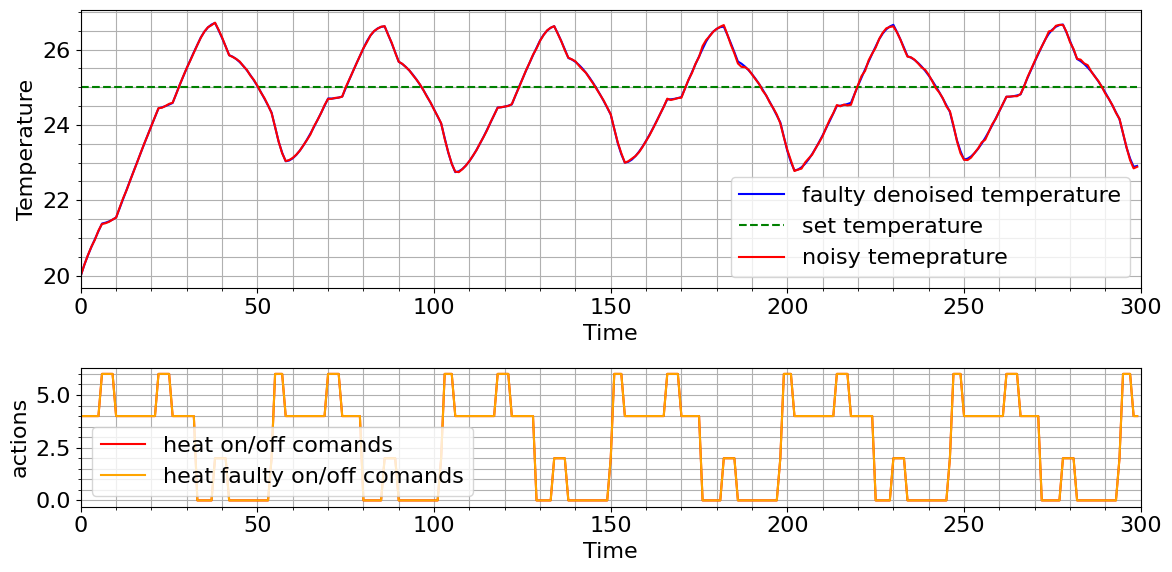

-14.949999999999989

In [ ]:
n0=0
t_set=298.15-kelvin
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(t_f[n0], 'b',label="faulty denoised temperature")
#axs[0].plot(t_out_f[n0], 'black',label="outside temperature")
axs[0].plot(t_set*np.ones(300), 'g',label="set temperature",linestyle='dashed')
axs[0].plot(noisy_t_f[n0], 'r',label="noisy temeprature")
axs[0].set_xlim(0, 300)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(a_f[n0], 'r',label="heat on/off comands")
#axs[1].plot(vent_f[0], 'b',label="ventilation on/off comands")
axs[1].plot(a_fault[n0], 'orange',label="heat faulty on/off comands")
#axs[1].plot(vent_fault[0], 'green',label="ventilation faulty on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()
plt.show()
t_out_f[n0,0]

In [ ]:
num=fault_type
level="low"
dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"

np.savez_compressed(dir, t_out_f=t_out_f, t_f=t_f,noisy_t_f=noisy_t_f,a_f=a_f,a_fault=a_fault)

# Data uploading

## train and test datasets

In [197]:
def prepare_dataset(npz_path, number_of_hid_units=3, size=-1):
    """
    Loads and reformats the dataset from the given npz file.
    Expected keys in the npz file:
      - t_out_c: outdoor temperature, shape (batch_size, session_length)
      - t_c: true indoor temperature (unused here)
      - noisy_t_c: observed indoor temperature, shape (batch_size, session_length)
      - a_c: HVAC actions, shape (batch_size, session_length)

    Returns a dictionary with keys:
      - 'actions': shape (batch_size, session_length), int32.
      - 'states':  shape (batch_size, session_length), float32.
      - 't_out':   shape (batch_size, session_length), float32.
      - 'eps':     shape (batch_size, session_length), float32.
      - 'initial_state': shape (batch_size, number_of_hid_units), float32.
    """
    data = np.load(npz_path)
    t_out_c = data["t_out_c"][:size,:]
    noisy_t_c = data["noisy_t_c"][:size,:]
    a_c = data["a_c"][:size,:]
    

    batch_size, session_length = noisy_t_c.shape
    eps = np.random.randn(batch_size, session_length).astype(np.float32)
    initial_state = np.random.randn(batch_size, number_of_hid_units).astype(np.float32)

    dataset_dict = {
        "actions": a_c.astype(np.int32),
        "states": noisy_t_c.astype(np.float32),
        "t_out": t_out_c.astype(np.float32),
        "eps": eps,
        "initial_state": initial_state
    }
    return dataset_dict
def prepare_dataset_from_split(npz_prefix, number_of_hid_units=3, size=-1):
    """
    Loads and reformats the dataset from multiple split npz files.
    Expected keys in each npz file:
      - t_out_c: outdoor temperature, shape (batch_size, session_length)
      - t_c: true indoor temperature (unused here)
      - noisy_t_c: observed indoor temperature, shape (batch_size, session_length)
      - a_c: HVAC actions, shape (batch_size, session_length)

    Args:
        npz_prefix: The prefix used to generate the split npz files (e.g., 'output_prefix' for files like 'output_prefix_part_1.npz')
        number_of_hid_units: Number of hidden units for the initial state.
        size: Number of samples to use (-1 for all).

    Returns a dictionary with keys:
      - 'actions': shape (batch_size, session_length), int32.
      - 'states':  shape (batch_size, session_length), float32.
      - 't_out':   shape (batch_size, session_length), float32.
      - 'eps':     shape (batch_size, session_length), float32.
      - 'initial_state': shape (batch_size, number_of_hid_units), float32.
    """
    # Find all split files matching the pattern
    split_files = glob.glob(f"{npz_prefix}_part_*.npz")
    if not split_files:
        raise ValueError(f"No split files found with prefix: {npz_prefix}")

    # Initialize lists to hold data from each split file
    t_out_c_list = []
    noisy_t_c_list = []
    a_c_list = []
    t_c_list = []

    # Load and concatenate data from each split file
    for file in sorted(split_files):
        data = np.load(file)
        t_out_c_list.append(data["t_out_c"])
        noisy_t_c_list.append(data["noisy_t_c"])
        a_c_list.append(data["a_c"])
        t_c_list.append(data["t_c"])

    # Concatenate along the batch dimension (axis=0)
    t_out_c = np.concatenate(t_out_c_list, axis=0)
    noisy_t_c = np.concatenate(noisy_t_c_list, axis=0)
    a_c = np.concatenate(a_c_list, axis=0)
    t_c = np.concatenate(t_c_list, axis=0)

    # Apply size limit if specified
    if size > 0:
        t_out_c = t_out_c[:size, :]
        noisy_t_c = noisy_t_c[:size, :]
        a_c = a_c[:size, :]
        t_c = t_c[:size, :]

    batch_size, session_length = noisy_t_c.shape
    eps = np.random.randn(batch_size, session_length).astype(np.float32)
    initial_state = np.random.randn(batch_size, number_of_hid_units).astype(np.float32)

    dataset_dict = {
        "actions": a_c.astype(np.int32),
        "states": noisy_t_c.astype(np.float32),
        "t_out": t_out_c.astype(np.float32),
        "true_states": t_c.astype(np.float32),
        "eps": eps,
        "initial_state": initial_state
    }
    return dataset_dict

def create_tf_dataset(dataset_dict, batch_size=2048*4):
    """
    Converts the dictionary into a tf.data.Dataset by slicing along the first dimension
    and batching. Each element will then have shape:
      - actions: (batch_size, session_length)
      - states:  (batch_size, session_length)
      - t_out:   (batch_size, session_length)
      - eps:     (batch_size, session_length)
      - initial_state: (batch_size, number_of_hid_units)
    """
    ds = tf.data.Dataset.from_tensor_slices(dataset_dict)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds



# Load and create datasets
train_data_dict = prepare_dataset_from_split("./dataset/train/data_set_full_v7", number_of_hid_units=number_of_hid_units, size=-1)
train_dataset = create_tf_dataset(train_data_dict,batch_size=2048)
test_data_dict = prepare_dataset_from_split("./dataset/test/data_set_full_v7_test", number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict,batch_size=1024)

## 2400 minute dataset

In [ ]:
test_data_dict = prepare_dataset("./data_set_full_v7_test_10x.npz", number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict)

## DR dataset

In [ ]:
#data= "/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train.npz"
#data= "/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr_train_heating.npz"
data= "./data_set_full_v5_dr_train_cooling.npz"
#data= "/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v5_dr.npz"
test_data_dict = prepare_dataset(data, number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict)



## Faulty data

In [ ]:
number_of_pieces = 1
session_length = 300

num=0
level="low"
dir="./data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"
test_data_dict = prepare_dataset(dir, number_of_hid_units=number_of_hid_units)
test_dataset = create_tf_dataset(test_data_dict)

# NN structure TF2.X

In [202]:
@register_keras_serializable()
class DenoisingDynamicsModel(tf.keras.Model):
    def __init__(self, session_length=session_length, number_of_hid_units=number_of_hid_units, **kwargs):
        """
        Constructs a model that first denoises the temperature (via a CNN)
        and then processes the denoised signal with a GRU and a fully connected (FC)
        network to compute the dynamics.
        """
        super(DenoisingDynamicsModel, self).__init__(**kwargs)
        self.session_length = session_length
        self.number_of_hid_units = number_of_hid_units
        
        # s is a constant; eta is a trainable parameter (both used in the loss)
        self.s = tf.constant(-5.0, dtype=tf.float32)
        self.eta = tf.Variable(-5.0, trainable=True, dtype=tf.float32, name='eta')

        # ---------------------------
        # Denoising CNN (using Conv1D layers)
        # ---------------------------
        # The CNN receives a tensor of shape (batch, session_length, 3)
        # (channels: [actions, states, t_out]) and outputs a tensor with 2 channels (mu and sigma).
        self.denoiser = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=8, kernel_size=8, padding='same',
                                   activation=tf.nn.elu,
                                   kernel_initializer='he_uniform', dtype=tf.float32),
            tf.keras.layers.Conv1D(filters=32, kernel_size=8, padding='same',
                                   activation=tf.nn.elu,
                                   kernel_initializer='he_uniform', dtype=tf.float32),
            tf.keras.layers.Conv1D(filters=8, kernel_size=8, padding='same',
                                   activation=tf.nn.elu,
                                   kernel_initializer='he_uniform', dtype=tf.float32),
            tf.keras.layers.Conv1D(filters=2, kernel_size=8, padding='same',
                                   activation=None,
                                   kernel_initializer='he_uniform', dtype=tf.float32)
        ], name='denoiser')

        # ---------------------------
        # GRU for dynamics
        # ---------------------------
        # The GRU processes inputs of shape (batch, session_length, 6) where the channels are:
        # one-hot encoded actions (depth 4), the true state (computed from mu and sigma) and t_out.
        self.gru = tf.keras.layers.GRU(units=number_of_hid_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dtype=tf.float32)

        # Fully connected network (“dynamics_net”) implemented as time distributed dense layers.
        self.dense1 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(16, activation=tf.nn.elu,
                                  kernel_initializer='he_uniform', dtype=tf.float32))
        self.dense2 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(1, kernel_initializer='he_uniform', dtype=tf.float32))

    def build(self, input_shape):
        # input_shape is a dictionary; assume input_shape['actions'] is (batch, session_length)
        actions_shape = input_shape['actions']
        session_length = actions_shape[1]  # Use dynamic batch size (None) for building layers

        # Build the denoiser with input shape: (None, session_length, 3)
        denoiser_input_shape = (None, session_length, 3)
        self.denoiser.build(denoiser_input_shape)

        # Build the GRU with input shape: (None, session_length, 6)
        gru_input_shape = (None, session_length, 6)
        self.gru.build(gru_input_shape)

        # Build the dense layers; dense1 expects input shape (None, session_length, number_of_hid_units)
        dense_input_shape = (None, session_length, self.number_of_hid_units)
        self.dense1.build(dense_input_shape)
        self.dense2.build(self.dense1.compute_output_shape(dense_input_shape))

        super(DenoisingDynamicsModel, self).build(input_shape)

    def call(self, inputs, training=False):
        """
        Expects a dictionary with the following keys:
          - 'actions': shape (batch, session_length), int32.
          - 'states': shape (batch, session_length), float32.
          - 't_out': shape (batch, session_length), float32.
          - 'eps': shape (batch, session_length), float32.
          - 'initial_state': shape (batch, number_of_hid_units), float32.
        """
        actions = inputs['actions']
        states = inputs['states']
        t_out = inputs['t_out']
        eps = inputs['eps']
        initial_state = inputs['initial_state']

        # ---------------------------------------
        # 1. Denoising CNN part
        # ---------------------------------------
        x = tf.concat([
            tf.cast(tf.expand_dims(actions, -1), tf.float32),
            tf.expand_dims(states, -1),
            tf.expand_dims(t_out, -1)
        ], axis=-1)  # shape: (batch, session_length, 3)

        conv_out = self.denoiser(x)  # shape: (batch, session_length, 2)
        mu = conv_out[..., 0]        # shape: (batch, session_length)
        sigma = conv_out[..., 1]     # shape: (batch, session_length)

        # Compute true state: mu + exp(sigma/2) * eps.
        true_state = mu + tf.exp(sigma / 2) * eps

        # ---------------------------------------
        # 2. Dynamical system part (RNN + FC net)
        # ---------------------------------------
        one_hot_actions = tf.one_hot(actions, depth=4, dtype=tf.float32)
        input_transform = tf.concat([
            one_hot_actions,
            tf.expand_dims(true_state, -1),
            tf.expand_dims(t_out, -1)
        ], axis=-1)  # shape: (batch, session_length, 6)

        gru_outputs = self.gru(input_transform, initial_state=initial_state)
        rnn_out = gru_outputs[0]  # (batch, session_length, number_of_hid_units)

        dyn_out = self.dense1(rnn_out)    # (batch, session_length, 16)
        dyn_out = self.dense2(dyn_out)    # (batch, session_length, 1)
        dyn_out = tf.squeeze(dyn_out, axis=-1)  # (batch, session_length)

        new_state = dyn_out + true_state  # (batch, session_length)

        # ---------------------------------------
        # 3. Time shifting and loss computation
        # ---------------------------------------
        mu_shift = mu[:, 1:]
        sigma_shift = sigma[:, 1:]
        T = states[:, 1:]
        F = new_state[:, :-1]

        sigma_term = tf.exp(sigma_shift) * (1/(2 * tf.exp(self.s)) + 1/(2 * tf.exp(self.eta)))
        regularization_term = tf.square(mu_shift - F) / (2 * tf.exp(self.s))
        log_sigma_term = -sigma_shift / 2
        regression_term = tf.square(T - mu_shift) / (2 * tf.exp(self.eta))

        loss = tf.reduce_mean(sigma_term + regularization_term +
                              log_sigma_term + regression_term +
                              self.s/2 + self.eta/2)

        return {
            'loss': loss,
            'mu': mu,
            'sigma': sigma,
            'true_state': true_state,
            'new_state': new_state
        }

    def t_denoising(self, noisy_t, t_out, action):
        """Handles both single-sample and batch inputs"""

        # Ensure 3D shape: [batch, time, features]
        x = tf.concat([
            tf.cast(tf.expand_dims(action, -1), tf.float32),
            tf.expand_dims(noisy_t, -1),
            tf.expand_dims(t_out, -1)
        ], axis=-1)  # (session_length, 3)

        # Add batch dimension if single sample
        if tf.rank(x) == 2:
            x = tf.expand_dims(x, 0)

        conv_out = self.denoiser(x)  # [batch, time, 2]
        mu, sigma = tf.split(conv_out, 2, axis=-1)
        return tf.squeeze(mu), tf.exp(tf.squeeze(sigma)/2)

    def get_new_hidden_state(self, hidden_actions, hidden_states, hidden_t_out):
        """Processes batches and single samples"""
        # Convert to 3D: [batch, time, features]
        x = tf.concat([
            tf.one_hot(hidden_actions, depth=4),          # [..., 4]
            tf.expand_dims(hidden_states, -1),            # [..., 1]
            tf.expand_dims(hidden_t_out, -1)              # [..., 1]
        ], axis=-1)

        # Add batch dim if single sample
        if tf.rank(x) == 2:
            x = tf.expand_dims(x, 0)

        # Process through GRU - returns [batch, time, units]
        gru_output = self.gru(x)
       
        
        # Case 1: Multiple states returned (one per sample)
        if len(gru_output) > 2:
            # Stack all individual states into a single tensor
            final_state = tf.stack(gru_output[1:])  # [batch, units]
            return final_state
        # Case 2: Standard (outputs, state) tuple
        elif len(gru_output) == 2:
            return gru_output[1]

    def predict_next_state(self, pred_actions, pred_states, pred_t_out, initial_state):
        """Batch-friendly prediction step"""
        # Ensure all tensors have matching batch dimensions
        # Create input features [batch, 1, 6]
        x = tf.concat([
            tf.one_hot(pred_actions, depth=4),          # [..., 4]
            tf.expand_dims(pred_states, -1),            # [..., 1]
            tf.expand_dims(pred_t_out, -1)              # [..., 1]
        ], axis=-1)
        
        # Ensure proper 3D shape
        if tf.rank(x) == 1:
            x = tf.expand_dims(x, 0)  # [1, 6] -> [1, 1, 6]
            x = tf.expand_dims(x, 0)
        elif tf.rank(x) == 2:
            x = tf.expand_dims(x, 1)  # [batch, 6] -> [batch, 1, 6]


        # GRU step - outputs: [batch, 1, units]
        gru_output = self.gru(x, initial_state=initial_state)
        if len(gru_output) > 2:
            # Stack all individual states into a single tensor
            new_hidden_state = tf.stack(gru_output[1:])  # [batch, units]
        # Case 2: Standard (outputs, state) tuple
        elif len(gru_output) == 2:
            new_hidden_state=gru_output[1]
        # Dense layers and output
        delta = self.dense2(self.dense1(gru_output[0]))  # [batch, 1, 1]
        return tf.squeeze(delta, [1, 2]), new_hidden_state  # [batch], [batch, units]


model = DenoisingDynamicsModel(session_length=session_length, number_of_hid_units=number_of_hid_units)
initial_learning_rate = 0.00005 # this method is sensitive to exploiding gradient, so an starting learning rate of 0.05 or less is recommended, for finetuning 0.0001 is recommended
decay_steps = 100 # as the model is data efficient, too large decay steps slow dow learning 
decay_rate = 0.99
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)


def train_model(model, dataset, optimizer, num_steps=10000, plot_interval=100): 
    losses = []
    best_loss = float('inf')
    best_weights = None

    plt.ion()  # Enable interactive mode for updating plots in Jupyter

    for step in tqdm(range(num_steps), desc='Training', leave=True):
        batch = next(iter(dataset))
        
        with tf.device('/GPU:0'):
            with tf.GradientTape() as tape:
                outputs = model(batch, training=True)
                loss = outputs['loss']
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            current_loss = loss.numpy()
            losses.append(current_loss)

            # Track best weights
            if current_loss < best_loss:
                best_loss = current_loss
                best_weights = model.get_weights()  # Creates a copy
                print(f"New best loss at step {step}: {best_loss:.4f}")
                model.save('./models/Model_V9_best_train.keras')

        if step % plot_interval == 0 and step > 0:
            print("loss at step", step, ":", current_loss)
    
    # Restore best weights at the end of training
    if best_weights is not None:
        model.set_weights(best_weights)
        print(f"Training complete. Restored weights with best loss: {best_loss:.4f}")
    
    return losses



# training loop



In [204]:
with tf.device('/GPU:0'):
    losses = train_model(model, train_dataset, optimizer, num_steps=1000, plot_interval=100)


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

New best loss at step 0: 0.2157
New best loss at step 2: 0.1929
New best loss at step 11: 0.1743
New best loss at step 33: 0.1714
New best loss at step 38: 0.1580
New best loss at step 52: 0.1513
loss at step 100 : 0.20166712
loss at step 200 : 0.19161797
New best loss at step 299: 0.1512
loss at step 300 : 0.19121893
loss at step 400 : 0.17445579
loss at step 500 : 0.1731849
New best loss at step 539: 0.1497
New best loss at step 591: 0.1440
loss at step 600 : 0.19916697
loss at step 700 : 0.19780402
loss at step 800 : 0.180539
New best loss at step 834: 0.1405
loss at step 900 : 0.16779782
Training complete. Restored weights with best loss: 0.1405


In [209]:
model.save( "./models/Model_V9.keras")

# Model recovery

In [203]:
model = tf.keras.models.load_model("./models/Model_V9.keras", custom_objects={"DenoisingDynamicsModel": DenoisingDynamicsModel})

# test functions


In [205]:
#functions for test, scoring and progress saving.
def test_batch(model, test_dataset, max_batches=None, session_length=300):
    """
    Evaluates model performance on test dataset with batch processing control
    
    Args:
        model: Trained model
        test_dataset: Prefetched TF Dataset
        max_batches: Maximum number of batches to process (None for all)
        session_length: Length of each session sequence
    """
    lengths = [30, 60, 90, 120, 150]
    metrics = {length: {'mse': [], 'mae': [], 'r2': []} for length in lengths}
    
    # Initialize batch counter
    batch_count = 0
    
    # Create progress bar
    pbar = tqdm(test_dataset, desc="Processing batches", total=max_batches)
    
    for batch in pbar:
        # Stop if we've reached max_batches
        if max_batches is not None and batch_count >= max_batches:
            break
            
        # Extract batch data [batch, time]
        a_hist = batch['actions'][:, :150]
        noisy_t_hist = batch['states'][:, :150]
        t_out_hist = batch['t_out'][:, :150]
        a_future = batch['actions'][:, 150:]
        t_out_future = batch['t_out'][:, 150:]
        true_future = batch['true_states'][:, 150:]

        # Denoise historical observations [batch, 150]
        denoised_hist, _ = model.t_denoising(noisy_t_hist, t_out_hist, a_hist)

        # Get initial hidden state [batch, hidden_units]
        initial_state = model.get_new_hidden_state(a_hist, denoised_hist, t_out_hist)
        
        # Initialize current state with last denoised value [batch]
        s = denoised_hist[:, -1]
        
        # Predict future steps iteratively
        predictions = []
        future_length = session_length - 150
        
        for i in range(future_length):
            delta, initial_state = model.predict_next_state(
                a_future[:, i],  # [batch]
                s,              # [batch]
                t_out_future[:, i],  # [batch]
                initial_state   # [batch, hidden_units]
            )
            s = s + delta  # Update state [batch]
            predictions.append(s)
        
        # Stack predictions [batch, future_length]
        predictions = tf.stack(predictions, axis=1)

        # Compute metrics for each horizon
        for length in lengths:
            if length > future_length:
                continue

            pred_trunc = predictions[:, :length]
            true_trunc = true_future[:, :length]

            # MSE [batch]
            mse = tf.reduce_mean(tf.square(true_trunc - pred_trunc), axis=1)
            metrics[length]['mse'].extend(mse.numpy())
            
            # MAE [batch]
            mae = tf.reduce_mean(tf.abs(true_trunc - pred_trunc), axis=1)
            metrics[length]['mae'].extend(mae.numpy())
            
            # R² [batch]
            ss_res = tf.reduce_sum(tf.square(true_trunc - pred_trunc), axis=1)
            y_mean = tf.reduce_mean(true_trunc, axis=1, keepdims=True)
            ss_tot = tf.reduce_sum(tf.square(true_trunc - y_mean), axis=1)
            r2 = 1 - (ss_res / (ss_tot + 1e-7))
            metrics[length]['r2'].extend(r2.numpy())
        
        # Update batch counter
        batch_count += 1
        pbar.set_postfix({'batches': batch_count})

    # Aggregate metrics
    results = {length: {
        'mse': np.mean(metrics[length]['mse']),
        'mae': np.mean(metrics[length]['mae']),
        'r2': np.mean(metrics[length]['r2'])
    } for length in lengths}
    
    # Add batch count to results
    results['batches_processed'] = batch_count
    
    return results

def compare_rows(row1, row2, range, n):
    """
    Compares two rows and returns a series indicating whether the values in row2 are outside
    the range defined by row1 ± range for more than 'n' consecutive time steps.

    Args:
    row1 (pd.Series): The first row to compare (reference row).
    row2 (pd.Series): The second row to compare.
    range (float): The range for the comparison.
    n (int): The number of initial time steps to be marked separately.

    Returns:
    pd.Series: A series with values:
               0 - within the range
               1 - outside the range for the first 'n' time steps
               2 - outside the range for more than 'n' consecutive time steps
    """
    # Ensure both rows have the same length
    if len(row1) != len(row2):
        raise ValueError("Both rows must have the same number of elements")

    result = []
    consecutive_outside = 0
    outside_band = False

    for val1, val2 in zip(row1, row2):
        if val2 < val1 - range or val2 > val1 + range:
            consecutive_outside += 1
            outside_band = True
        else:
            consecutive_outside = 0
            outside_band = False

        if outside_band:
            if consecutive_outside <= n:
                result.append(1)
            else:
                result.append(2)
        else:
            result.append(0)

    return pd.Series(result)


def DR_test_batch( t, a, t_out,dr, index, confort_lim, size):
  """

  Args:
    t: denoised modelled room temperature
    a:modelled HVAC action coded vector
    t_out: Mocelled temperature outside of the room
    size: int- select the first n elements of the passed test dataset

  Returns:
    t_test_final: nested list with all the predicted temperatures, each list one data sequence


  """

  t_test_final=[]
  index_pred=[]
  offset=[]
  offset_pred=[]

  if size<= len(t):
    for i in tqdm(range(size)):
      start=dr[i].nonzero()[0][0]-1
      a[i,start:]=0
      t_future,t_test=test_step( t[i], a[i], t_out[i])
      t_test_final.append(t_test)
      if np.count_nonzero((abs(t_test[start-150:]-conf_lim[i])<0.15))>0:
        index_pred_i=(abs(t_test[start-150:]-conf_lim[i])<0.15).nonzero()[0][0]+start
        if index[i][0]==0:
          offset.append(299-start)
        else:
          offset.append(index[i][0]-start)
        offset_pred.append(index_pred_i-start)
      else:
        index_pred_i=0
        offset.append(0)
        offset_pred.append(0)
      index_pred.append(index_pred_i)


  else:
    print("Error: the data set is smaller than the given size")
    t_test_final.append(np.nan)

  offset=np.array(offset)
  offset_pred=np.array(offset_pred)
  bias=offset_pred-offset

  return t_test_final, index_pred,offset,offset_pred,bias


def test_batch_fault( t, a, t_out,size):
  """

  Args:
    t: denoised modelled room temperature
    a:modelled HVAC action coded vector
    t_out: Mocelled temperature outside of the room
    size: int- select the first n elements of the passed test dataset

  Returns:
    t_test_final: nested list with all the predicted temperatures, each list one data sequence
    mse_f:list of mse for each data sequence
    mae_f:list of mae for each data sequence
    rmse_f:list of rmse for each data sequence
    r2_f: list of r2 for each data sequence

  """

  t_test_final=[]
  if size<= len(t):
    for i in tqdm(range(size)):
      t_future,t_test=test_step( t[i], a[i], t_out[i])
      t_test_final.append(t_test)

  else:
    print("Error: the data set is smaller than the given size")
    t_test_final.append(np.nan)

  return t_test_final
def fault_response_time(t_matrix, t_hat_matrix, window_size, reference_value, rmse_threshold, RMSE=True):
    num_vectors, vector_length = t_matrix.shape
    indices = []  # To store the end index where RMSE exceeds the reference value
    start = []  # To store the starting index where RMSE falls below rmse_threshold

    for i in range(num_vectors):
        t = t_matrix[i]
        t_hat = t_hat_matrix[i]

        # Create a matrix where each row is a sliding window for the current vector
        t_windows = np.lib.stride_tricks.sliding_window_view(t, window_shape=window_size)
        t_hat_windows = np.lib.stride_tricks.sliding_window_view(t_hat, window_shape=window_size)

        # Vectorized calculation of RMSE (or simple error) for each window
        if RMSE:
            errors = np.sqrt(np.mean((t_windows - t_hat_windows) ** 2, axis=1))  # RMSE
        else:
            errors = np.mean(np.abs(t_windows - t_hat_windows), axis=1)  # Mean absolute error (if not RMSE)

        # Find the first window where error exceeds the reference value
        exceeding_index = np.argmax(errors > reference_value)

        # If no window exceeds the reference value, default to 150
        if errors[exceeding_index] <= reference_value:
            indices.append(150)
            start.append(150)
        else:
            # Find the first window before exceeding_index where error falls below rmse_threshold
            pre_exceeding_errors = errors[:exceeding_index]

            # Only check for `rmse_threshold` if there are valid windows before `exceeding_index`
            if len(pre_exceeding_errors) > 0:
                reverse_index = np.argmax(np.flip(pre_exceeding_errors) < rmse_threshold)
                # Check if a valid index was found (flip didn't find any valid window)
                if np.flip(pre_exceeding_errors)[reverse_index] >= rmse_threshold:
                    start.append(150)  # No point found below threshold
                else:
                    start.append(exceeding_index - reverse_index - 1 + window_size - 1)
            else:
                start.append(150)  # No valid windows before exceeding_index

            indices.append(exceeding_index + window_size - 1)
    return np.array(indices), np.array(start)








# Testing

## testing a single prediction

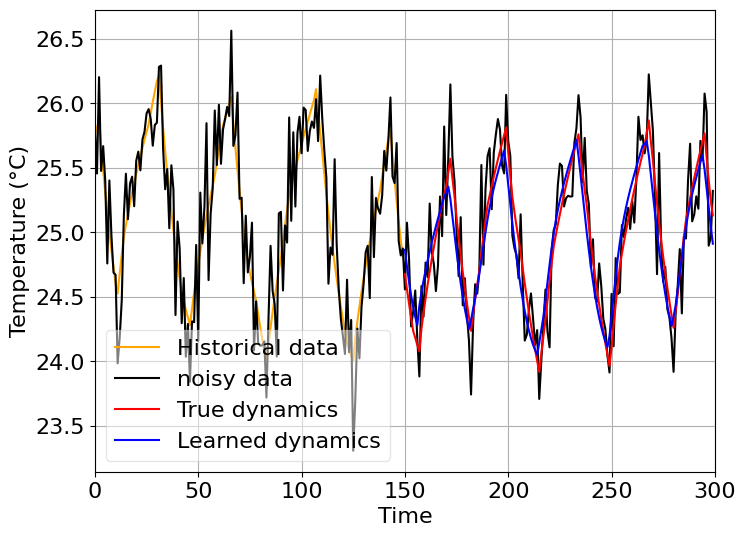

In [206]:
'''piece of code for testing of prediction'''
"""for controlled environment"""
init_t = (298.15, 20, 298.15, 298.15, 303.85,0)
#temperature of air, vent. level,  temperature of heater, temperature wall, temperature outside, this values is also used as an average temperature for the calculated period,  1 t_out is constant,0 it is modeled'''
'''sample true dynamics'''
'''piece of code for testing of prediction'''

'''initializing env.'''
env_t = environment(init_t)
session_length = 600
std_of_noise = 0.3
t_set=298.15
v_set=20
dt= 1
dv= 5
'''sample true dynamics'''

t, noisy_t, a, t_out =  env_t.controlled_session(session_length, std_of_noise,t_set,v_set,dt,dv)
t_test=t[:300]-273.13
t=t[300:]-273.13

noisy_t=noisy_t[300:] -273.13
t_out=t_out[300:]-273.13
'''historical data for extracting GRU hidden state'''
a_dec= np.zeros((0,1), dtype=int)
for i in range(len(a)):
  y=to_bin(a[i])
  a_dec=np.append(a_dec,np.array([y]).reshape((1,1)), axis=0)
a_dec=a_dec[300:]
t_hist = t[:150].reshape((1, -1))
a_hist = a_dec[:150].reshape((1, -1))
t_out_hist = t_out[:150].reshape((1, -1))
noisy_t_hist=noisy_t[:150].reshape((1, -1))
'''future data, we are going to predict'''
t_future = t[150:].reshape((1, -1))
a_future = a_dec[150:].reshape((1, -1))
t_out_future = t_out[150:].reshape((1, -1))
noisy_t_future=noisy_t[150:].reshape((1, -1))
initial_state = model.get_new_hidden_state(tf.convert_to_tensor(a_hist, dtype=tf.int32), tf.convert_to_tensor(t_hist, dtype=tf.float32), tf.convert_to_tensor(t_out_hist, dtype=tf.float32))
if len(initial_state.shape) == 1:
    initial_state = tf.expand_dims(initial_state, 0)
denoised_hist=model.t_denoising(tf.convert_to_tensor(noisy_t_hist, dtype=tf.float32),tf.convert_to_tensor(t_out_hist, dtype=tf.float32),tf.convert_to_tensor(a_hist, dtype=tf.int32))
outputs=[]
s=denoised_hist[0][-1]
for i in range(t_future.shape[1]):
  delta,initial_state = model.predict_next_state(tf.convert_to_tensor(a_future[0][i], dtype=tf.int32), s,tf.convert_to_tensor(t_out_future[0][i], dtype=tf.float32),initial_state)
  initial_state = tf.expand_dims(initial_state, 0)
  #initial_state=initial_state
  s=s+delta[0]
  #s=tf.squeeze(s),
  outputs.append(s),

# Prepare the true future dynamics (they are in t_future, shape (1, future_len))
true_future = t_future.flatten()

# --- Plotting the Results ---
fig, ax = plt.subplots(figsize=(8, 6))

# Plot historical data (used to extract hidden state)
ax.plot(range(150), t_hist.flatten(), 'orange', label='Historical data')

ax.plot(range(300), noisy_t.flatten(), 'black', label='noisy data')

# Plot true future dynamics. We start the x-axis at 150 to indicate that historical data covers 0-149.
ax.plot(range(150, 150 + len(true_future)), true_future, 'red', label='True dynamics')

# Plot predicted dynamics from the NN
ax.plot(range(150, 150 + len(outputs)), outputs, 'blue', label='Learned dynamics')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_xlim(0, 150 + len(true_future))
ax.legend(loc='best', framealpha=0.5)
ax.grid(True)
plt.show()

In [164]:
fig.savefig('./general_test_pred.pdf', format='pdf')


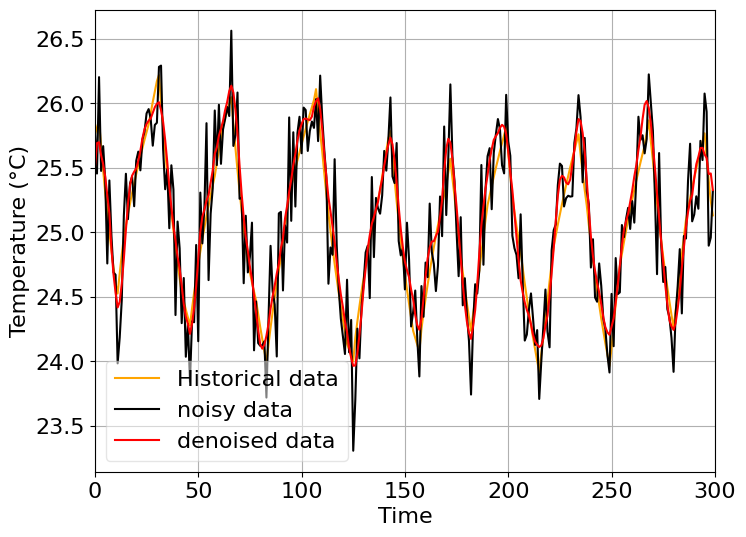

In [207]:
denoised=model.t_denoising(tf.convert_to_tensor(noisy_t.reshape((1, -1)), dtype=tf.float32),tf.convert_to_tensor(t_out.reshape((1, -1)), dtype=tf.float32),tf.convert_to_tensor(a_dec.reshape((1, -1)), dtype=tf.int32))
#denoised signa plotting 
fig, ax = plt.subplots(figsize=(8, 6))

# Plot historical data (used to extract hidden state)
ax.plot(range(300), t.flatten(), 'orange', label='Historical data')

ax.plot(range(300), noisy_t.flatten(), 'black', label='noisy data')

ax.plot(range(300), denoised[0], 'red', label='denoised data')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_xlim(0, 300 )
ax.legend(loc='best', framealpha=0.5)
ax.grid(True)
plt.show()

In [ ]:
fig.savefig('./general_test_denoised.pdf', format='pdf')


## testing a batch of predictions

In [208]:
test_results = test_batch(model,test_dataset, session_length=300, max_batches=10)
keys=list(test_results)
for length in keys[:-1]:
    print(f"Horizon {length}:")
    print(f"  MSE: {test_results[length]['mse']:.4f}")
    print(f"  MAE: {test_results[length]['mae']:.4f}")
    print(f"  R²: {test_results[length]['r2']:.4f}\n")


Processing batches:   0%|          | 0/10 [00:00<?, ?it/s]

2025-04-28 19:12:03.569671: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Horizon 30:
  MSE: 0.1236
  MAE: 0.2474
  R²: -86.5477

Horizon 60:
  MSE: 0.2313
  MAE: 0.3130
  R²: -315.9182

Horizon 90:
  MSE: 0.6188
  MAE: 0.4418
  R²: -703.5199

Horizon 120:
  MSE: 1.7698
  MAE: 0.6313
  R²: -1292.8743

Horizon 150:
  MSE: 4.6641
  MAE: 0.9143
  R²: -1927.0173



## Save test data

In [ ]:


def create_dataframe( list1, list2, list3, column_names=None):
    """
    Creates a pandas DataFrame from five lists, using each list as a column.

    Parameters:
    - list1, list2, list3, list4, list5: The lists to be used as columns in the DataFrame.
    - column_names: Optional list of column names. If not provided, default names will be used.

    Returns:
    - A pandas DataFrame with the provided lists as columns.
    """
    data = {
        'Column1': list1,
        'Column2': list2,
        'Column3': list3
    }

    if column_names:
        if len(column_names) != 3:
            raise ValueError("The number of column names must be exactly 4.")
        data = {column_names[i]: lst for i, lst in enumerate([list1, list2, list3])}


    df = pd.DataFrame(data)

    return df


In [ ]:
test_data=create_dataframe( mse, mae, r2,column_names=[ 'mse', 'mae', 'r2' ])
t_t_df=pd.DataFrame(zip(*t_t)).transpose()
t_df=pd.DataFrame(zip(*t_c_test[8*500:8*500+len(t_t_df)])).transpose()
test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_metrics_10x.csv', index=False)
t_t_df.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_pred_10x.csv', index=False)
t_df.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_10x.csv', index=False)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_windows_10x.csv', index=False)

## Restore test data

In [ ]:
test_metrics=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_metrics_10x.csv')
test_pred=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_pred_10x.csv')
test_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_10x.csv')
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BML models/Test models/test_data_windows_10x.csv')


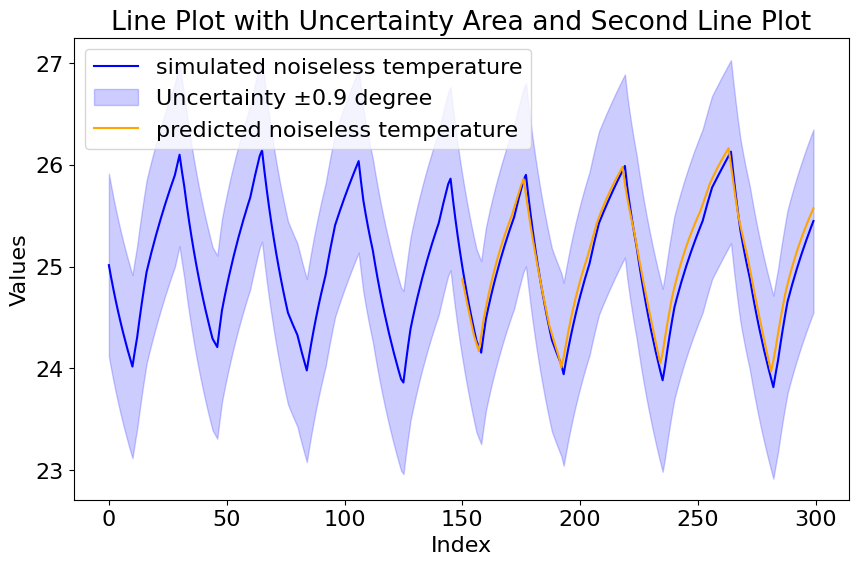

In [ ]:
number_of_pieces = 1
session_length = 300
element = 1 #ok example
n = 15  # Number of time steps for yellow highlight
consecutive_outside=0
# Extracting the rows
row1 = test_data.iloc[element]
row2 = test_pred.iloc[element].reset_index(drop=True)
comp_row = row1[150:session_length].reset_index(drop=True)
uncertainty=0.9
# X values for the plots
x1 = range(session_length)
x2 = range(150, session_length)

# Plotting
plt.figure(figsize=(10, 6))

# Line plot for the first row
plt.plot(x1, row1, label='simulated noiseless temperature', color='blue')

# Area of uncertainty
plt.fill_between(x1, row1 - uncertainty, row1 + uncertainty, color='blue', alpha=0.2, label='Uncertainty ±'+str(uncertainty)+ ' degree')

# Line plot for the second row (values 150 to 300)
plt.plot(x2, row2, label='predicted noiseless temperature', color='orange')

# Highlight areas where row2 is outside the uncertainty band
outside = (row2 < comp_row - uncertainty) | (row2 > comp_row + uncertainty)

start = None

for i in range(len(x2)):
    if outside.iloc[i]:
        if start is None:
            start = x2[i]
        consecutive_outside += 1
    else:
        if start is not None:
            if consecutive_outside <= n:
                plt.axvspan(start, x2[i-1], color='yellow', alpha=0.3)
            else:
                plt.axvspan(start, x2[i-1], color='red', alpha=0.3)
            start = None
            consecutive_outside = 0

# Check if the last segment needs highlighting
if start is not None:
    if consecutive_outside <= n:
        plt.axvspan(start, x2[-1], color='yellow', alpha=0.3)
    else:
        plt.axvspan(start, x2[-1], color='red', alpha=0.3)

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Line Plot with Uncertainty Area and Second Line Plot')
plt.legend()

# Display the plot
plt.show()

In [ ]:
n=20
df_range1 = pd.DataFrame().reindex_like(test_pred)
for i in test_data.index.values:
  place_h= compare_rows( test_data.iloc[i][150:session_length].reset_index(drop=True), test_pred.iloc[i].reset_index(drop=True),0.25,n)
  df_range1.iloc[i]=place_h


In [ ]:
confidense_pred_1c=1-df_range1.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range1.sum(axis=1))

In [ ]:
confidense_pred_1c

0.278

In [ ]:
df_range05 = pd.DataFrame().reindex_like(test_pred)
for i in test_data.index.values:
  place_h= compare_rows( test_data.iloc[i][150:300].reset_index(drop=True), test_pred.iloc[i].reset_index(drop=True),0.5,n)
  df_range05.iloc[i]=place_h


In [ ]:
confidense_pred_05c=1-df_range05.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range05.sum(axis=1))

In [ ]:
confidense_pred_05c

0.848

In [ ]:
N=[0,5,10,15,20,25,30]
K=[30,60,90,120,150]
T=0.25

In [ ]:
VAL=[]
for n in N:
  val=[]
  for k in K:
    df_range1_r = pd.DataFrame().reindex_like(test_pred.iloc[:, : k])
    for i in test_data.index.values:
      place_h= compare_rows( test_data.iloc[i][150:150+k].reset_index(drop=True), test_pred.iloc[i][:k].reset_index(drop=True),T,n)
      df_range1_r.iloc[i]=place_h
    confidense_pred=1-df_range1_r.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range1_r.sum(axis=1))
    val.append(confidense_pred)
  VAL.append(val)
  
print(VAL)

In [ ]:
df_range05_r = pd.DataFrame().reindex_like(test_pred.iloc[:, : 60])
for i in test_data.index.values:
  place_h= compare_rows( test_data.iloc[i][150:210].reset_index(drop=True), test_pred.iloc[i][:60].reset_index(drop=True),0.1,n)
  df_range05_r.iloc[i]=place_h
confidense_pred_05c_r=1-df_range05_r.apply(lambda row: (row >= 2).any(), axis=1).sum()/len(df_range05_r.sum(axis=1))
confidense_pred_05c_r

0.538

# test: DR


In [ ]:
t_t,index_pred,offset,offset_pred,bias = DR_test_batch( t_dr, a_dr, t_out_dr,dr, index, conf_lim, size=500)

index=index+(index==0)*300
index_pred=np.array(index_pred)
index_pred=index_pred+(index_pred==0)*300

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
np.mean(bias)

-1.824

In [ ]:
np.sqrt(np.var(bias))

2.303263771260253

In [ ]:
np.sqrt( mean_squared_error(index[:500].flatten(), index_pred))

2.944146735473624

In [ ]:
np.sqrt( mean_squared_error(index[:500].flatten(), index_pred))

2.944146735473624

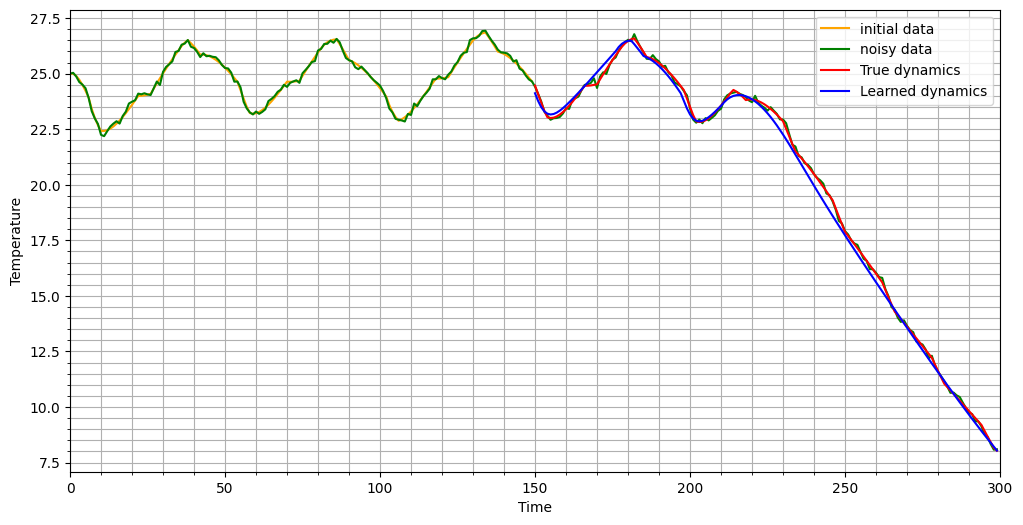

array([237.])

In [ ]:
#element to visualise
n=0
t=t_dr[+n]
noisy_t=noisy_t_dr[+n]
t_test=t_t[n]
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(6)
axs.plot(range(150), t[:150],'orange',label='initial data')
axs.plot(range(session_length), noisy_t,'green',label='noisy data')
axs.plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs.plot(range(150,session_length),t_test, 'blue',label="Learned dynamics")
axs.set_xlim(0, session_length)
axs.set_xlabel('Time')
axs.set_ylabel('Temperature')
axs.grid(True)
axs.grid(which = "minor")
axs.minorticks_on()
axs.legend()
plt.show()
index[n]

# Fault test  

## individual test

In [ ]:
n=5
t=t_f[+n]
noisy_t=noisy_t_f[+n]
a_dec=a_f[+n]
t_out=t_out_f[+n]
a_faulty=a_fault[+n]

t_hist = t[:150].reshape((1, -1))
a_hist = a_dec[:150].reshape((1, -1))
t_out_hist = t_out[:150].reshape((1, -1))

'''future data, we are going to predict'''
t_future = t[150:]
a_future = a_dec[150:]
t_out_future = t_out[150:]

'''current temperature of prediction'''
s = np.array(t[150])

'''extraction of hidden GRU state using historical data'''
in_rnn_state = extract_hidden_state( t_hist, a_hist, t_out_hist)
print(t_out[0])
'''prediction loop'''

'''initializing t collection'''
t_test = []
for i in range(session_length-150):

    '''update temperature (s) and hidden GRU state'''
    s, in_rnn_state = dyn_predict(s, a_future[i], t_out_future[i], in_rnn_state)


    '''adding to t collection'''
    t_test.append(s)

t_test = np.array(t_test).flatten()
'''plotting of example'''
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(8)
fig.set_figheight(6)
axs[0].plot(range(150), t[:150],'orange',label='Initial data')
axs[0].plot(range(session_length), noisy_t,'green',label='Noisy data')
axs[0].plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs[0].plot(range(150,session_length),t_test, 'blue',label="Learned dynamics")
axs[0].set_xlim(0, session_length)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend()
axs[1].plot(a_dec, 'r',label="HVAC commands")
axs[1].plot(a_faulty, 'b',label="HVAC real commands")
#axs[1].plot(ac_c[n0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()



plt.show()
fig.savefig('filename.eps', format='eps')

NameError: name 'extract_hidden_state' is not defined

## batch test

In [ ]:

t_t =np.array(test_batch_fault( t_c_test, a_c_test, t_out_c_test,size=500))
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_pred.npz",t_t=t_t )

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
number_of_pieces = 1
session_length = 300

num=2
level="low"
dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise.npz"
data_f= np.load(dir)
data_test= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_full_v7_test.npz")



t_out_f=np.vstack((data_f["t_out_f"],data_test["t_out_c"][:500]))
t_f=np.vstack((data_f["t_f"],data_test["t_c"][:500]))
noisy_t_f=np.vstack((data_f["noisy_t_f"],data_test["noisy_t_c"][:500]))
a_f=np.vstack((data_f["a_f"],data_test["a_c"][:500]))
a_fault=np.vstack((data_f['a_fault'],data_test["a_c"][:500]))

dir="/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_"+str(num)+"_"+str(level)+"_noise_pred.npz"
data= np.load(dir)

data_t= np.load("/content/drive/MyDrive/Colab Notebooks/BML dataset/data_set_fault_pred.npz")
t_t=np.vstack((data["t_t"],data_t["t_t"]))

In [ ]:
t_out_f

array([[-14.95      , -14.95156737, -14.94457762, ..., -13.54437361,
        -13.54276269, -13.53697612],
       [-12.25      , -12.24646992, -12.24725246, ..., -10.99264071,
        -10.99475914, -10.99285677],
       [ -9.45      ,  -9.44957886,  -9.44163362, ...,  -8.05639774,
         -8.0534877 ,  -8.05058769],
       ...,
       [-11.01389771, -11.01027067, -11.01404372, ..., -10.90783524,
        -10.90637144, -10.9092483 ],
       [-10.91024445, -10.91619343, -10.92099204, ..., -12.48921929,
        -12.4958017 , -12.50109146],
       [-12.50467537, -12.5124511 , -12.51699857, ..., -14.36594134,
        -14.36075973, -14.35502808]])

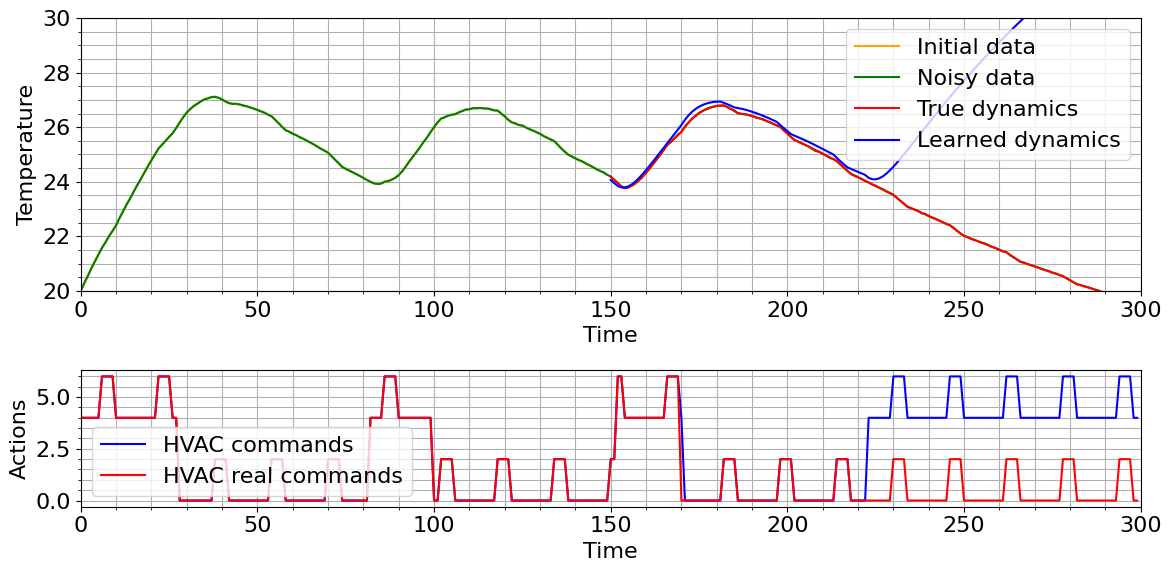

In [ ]:
n=10
t=t_f[+n]
t_pred=t_t[+n]
noisy_t=noisy_t_f[+n]
a_dec=a_f[+n]
t_out=t_out_f[+n]
a_faulty=a_fault[+n]
fig, axs = plt.subplots(2, 1,gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(12)
fig.set_figheight(6)
axs[0].plot(range(150), t[:150],'orange',label='Initial data')
axs[0].plot(range(session_length), noisy_t,'green',label='Noisy data')
axs[0].plot(range(150,session_length), t[150:],'red',label="True dynamics")
axs[0].plot(range(150,session_length),t_pred, 'blue',label="Learned dynamics")
#axs[0].axvspan(150+deviation[n],150+detection[n],color = 'b', label = 'Detection span '+str(detection[n]-deviation[n])+'min',alpha=0.2)
axs[0].set_xlim(0, session_length)
axs[0].set_ylim(20, 30)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature')
axs[0].grid(True)
axs[0].grid(which = "minor")
axs[0].minorticks_on()
axs[0].legend(loc=0)
axs[1].plot(a_dec, 'b',label="HVAC commands")
axs[1].plot(a_faulty, 'r',label="HVAC real commands")
#axs[1].plot(ac_c[n0], 'g',label="ac on/off comands")
axs[1].set_xlim(0, 300)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Actions')
axs[1].grid(True)
axs[1].legend()
axs[1].grid(which = "minor")
axs[1].minorticks_on()
fig.tight_layout()

In [ ]:

def find_first_differences(matrix, t_hat):
    # Ensure both matrix and t_hat have the same number of rows
    if matrix.shape[0] != t_hat.shape[0]:
        raise ValueError("The number of vectors in the matrix and t_hat must be the same.")

    num_vectors = matrix.shape[0]
    results = []

    for i in range(num_vectors):
        vector1 = matrix[i]
        vector2 = t_hat[i]

        # Create a boolean array where elements are different
        differences = vector1 != vector2

        # Find the index of the first difference
        first_diff_index = np.argmax(differences)  # np.argmax returns the first maximum index (True)

        # Check if there was a difference found
        if differences[first_diff_index]:
            results.append(first_diff_index-150)
        else:
            results.append(150)  # No difference found

    return np.array(results)
import numpy as np

def first_out_of_tolerance_index(matrix1, matrix2, tolerance=1e-6):
    """
    Compare two matrices and return the index of the first value in each row
    where the difference between matrix1 and matrix2 exceeds the given tolerance.

    Args:
        matrix1 (np.ndarray): The first matrix.
        matrix2 (np.ndarray): The second matrix.
        tolerance (float): The tolerance within which values are considered "equal".

    Returns:
        list: List of column indices for the first out-of-tolerance value in each row.
              If no value in a row exceeds the tolerance, it returns -1 for that row.
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions.")

    # Calculate the absolute difference between the two matrices
    diff = np.abs(matrix1 - matrix2)

    # Find where the difference exceeds the tolerance
    mask = diff > tolerance

    # List to store the first out-of-tolerance index for each row
    first_out_of_tolerance = []

    # Iterate over rows to find the first column index where the tolerance is exceeded
    for row_mask in mask:
        col_idx = np.argmax(row_mask)  # Find the first 'True' value in the row mask
        if row_mask[col_idx]:  # Ensure that the column index corresponds to an out-of-tolerance value
            first_out_of_tolerance.append(col_idx)
        else:
            first_out_of_tolerance.append(-1)  # If no value in the row is out of tolerance

    return first_out_of_tolerance





In [ ]:
ref=[0.1,0.204,0.204*1.25,0.204*1.5,0.204*1.75,0.204*2,0.204*2.25,0.204*2.5,0.204*2.75,0.204*3,0.204*4]
#ref=[0,-0.1,-0.204,-0.204*1.25,-0.204*1.5,-0.204*1.75,-0.204*2,-0.204*2.25,-0.204*2.5,-0.204*2.75,-0.204*3,-0.204*4,-0.204*5,-0.204*6,-0.204*10,-0.204*15]
precision=[]
recall=[]
time=[]
for i in ref:
  detection,deviation=fault_response_time(t_f[:,150:], np.array(t_t), window_size=10, reference_value=i,rmse_threshold=ref[-1]*0.3 ,RMSE= True )
  deviation=find_first_differences(a_f,a_fault)
  gr_true=deviation!=150
  #gr_true[:500]=1
  #gr_true[:500]=gr_true[:500]*pred[:500]
  pred=detection!=150
  time_i=detection- deviation
  time_i=time_i[time_i>0]
  time.append(time_i.mean())
  precision.append(precision_score(gr_true,pred))
  recall.append( recall_score(gr_true,pred))


In [ ]:
time

[1.0,
 2.136904761904762,
 2.554913294797688,
 3.1853932584269664,
 3.5280898876404496,
 4.129213483146067,
 4.477528089887641,
 4.966292134831461,
 5.337078651685394,
 5.578651685393258,
 7.258426966292135]

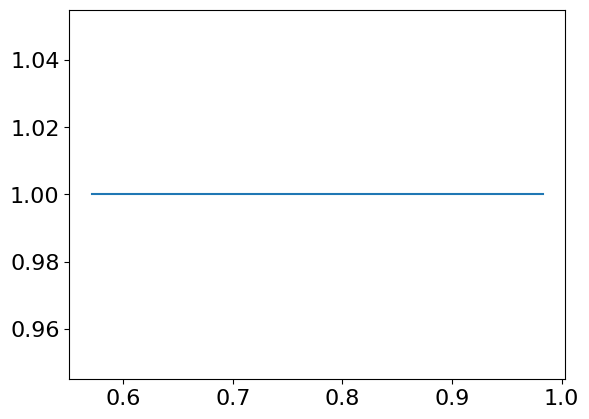

In [ ]:
plt.plot(precision,recall)


In [ ]:
precision

[0.19201725997842503,
 0.2176039119804401,
 0.24250681198910082,
 0.2692889561270802,
 0.29276315789473684,
 0.332089552238806,
 0.37872340425531914,
 0.4746666666666667,
 0.577922077922078,
 0.6926070038910506,
 0.9672131147540983]

In [ ]:
recall

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9943820224719101]

# Auxiliary functions

In [9]:
def split_npz(input_file, output_prefix, max_size_mb=100):
    # Load the original data into memory
    with np.load(input_file) as data:
        arrays = {key: data[key][:] for key in data.files}
    
    # Check all arrays have the same length along the first dimension
    n_vectors = None
    for key in arrays:
        if n_vectors is None:
            n_vectors = arrays[key].shape[0]
        else:
            assert arrays[key].shape[0] == n_vectors, "All arrays must have the same number of vectors"
    
    # Calculate total bytes per vector across all arrays
    per_vector_bytes = 0
    for key in arrays:
        arr = arrays[key]
        # Assuming each array is 2D with shape (n_vectors, 300)
        per_vector_bytes += arr.shape[1] * arr.dtype.itemsize
    
    # Calculate maximum vectors per chunk
    max_bytes = max_size_mb * 1024 * 1024  # Convert MB to bytes
    max_vectors_per_chunk = max_bytes // per_vector_bytes
    
    if max_vectors_per_chunk == 0:
        raise ValueError("Each vector is too large to fit within the size limit. Cannot split.")
    
    # Determine the number of chunks needed
    num_chunks = (n_vectors + max_vectors_per_chunk - 1) // max_vectors_per_chunk
    
    # Split and save each chunk
    for i in range(num_chunks):
        start_idx = i * max_vectors_per_chunk
        end_idx = start_idx + max_vectors_per_chunk
        chunk = {key: arrays[key][start_idx:end_idx] for key in arrays}
        output_filename = f"{output_prefix}_part_{i+1}.npz"
        np.savez_compressed(output_filename, **chunk)
        print(f"Saved: {output_filename}")

In [11]:
split_npz('../data_set_full_v7_test.npz', 'dataset/test/data_set_full_v7_test',max_size_mb=50)

Saved: dataset/test/data_set_full_v7_test_part_1.npz
Saved: dataset/test/data_set_full_v7_test_part_2.npz
Saved: dataset/test/data_set_full_v7_test_part_3.npz
Saved: dataset/test/data_set_full_v7_test_part_4.npz
Saved: dataset/test/data_set_full_v7_test_part_5.npz
Saved: dataset/test/data_set_full_v7_test_part_6.npz
Saved: dataset/test/data_set_full_v7_test_part_7.npz
Saved: dataset/test/data_set_full_v7_test_part_8.npz
Saved: dataset/test/data_set_full_v7_test_part_9.npz
